This notebook implements the ML Baseline (Phase 1) using XGBoost with HOG features. It extracts HOG features from the best (sharpest) frame per video, caches progress, performs hyperparameter grid search with checkpointing, and saves the best model.


In [11]:
import os
import cv2
import json
import joblib
import numpy as np
import pandas as pd
from pathlib import Path
from skimage.feature import hog
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import itertools
from xgboost.callback import TrainingCallback


# Set paths 
BASE_DIR = Path("C:/Users/abhis/Downloads/Documents/Learner Engagement Project")
DATA_DIR = BASE_DIR / "data" / "DAiSEE"
FRAMES_DIR = DATA_DIR / "ExtractedFrames"    
LABELS_DIR = DATA_DIR / "Labels"
MODEL_DIR = BASE_DIR / "models"
FEATURE_CACHE_DIR = MODEL_DIR / "hog_features"   # Directory to save per-video HOG feature files
CHECKPOINT_FILE = MODEL_DIR / "xgboost_hog_checkpoint.json"
FINAL_MODEL_PATH = MODEL_DIR / "xgboost_hog_model.json"

# Create directories if they don't exist
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(FEATURE_CACHE_DIR, exist_ok=True)

# For reproducibility
np.random.seed(42)

# Helper Functions

This section defines the following helper functions:

- **get_csv_clip_id**: Maps a video clip ID (file stem) to its corresponding folder name using custom mapping logic.
- **select_top_frames**: From all frames in a video folder, this function:

  - Detects faces using Haar cascades.
  - Computes a quality score based on the sharpness of the face region (with a fallback to the full frame if no face is detected).
  - Selects the top N frames with the highest quality scores.

- **extract_hog_from_image**: Reads an image in grayscale and computes HOG (Histogram of Oriented Gradients) features.

- **process_video_for_hog**:
  - Selects the top frames for a given video.
  - Extracts HOG features from each selected frame.
  - Averages the HOG features to form a single feature vector per video.
  - Caches the resulting feature vector for future use.


In [12]:
def get_csv_clip_id(video_stem: str) -> str:
    """
    Maps the given video stem using your mapping rule.
    For example, if the video_stem starts with "110001", replace with "202614".
    """
    base = video_stem.strip()
    if base.startswith("110001"):
        base = base.replace("110001", "202614", 1)
    return base

def select_top_frames(video_folder: Path, num_frames=30):
    """
    Given a folder of frames, select up to num_frames that are best for face detection.
    For each frame, a Haar cascade is used to detect faces. If a face is detected,
    we compute the sharpness (variance of Laplacian) over the face region (largest face).
    If no face is detected, we fall back to computing sharpness over the full image.
    Frames are then ranked by quality, and the top ones are returned.
    """
    # Load Haar cascade for face detection (using OpenCV's built-in path)
    cascade_path = cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
    face_cascade = cv2.CascadeClassifier(cascade_path)

    frame_files = sorted(video_folder.glob("frame_*.jpg"))
    quality_list = []
    for fp in frame_files:
        img = cv2.imread(str(fp))
        if img is None:
            continue
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)
        if len(faces) > 0:
            # Choose the largest detected face (by area)
            face = max(faces, key=lambda r: r[2]*r[3])
            x, y, w, h = face
            face_region = gray[y:y+h, x:x+w]
            quality = cv2.Laplacian(face_region, cv2.CV_64F).var()
        else:
            # Fallback: use full frame sharpness
            quality = cv2.Laplacian(gray, cv2.CV_64F).var()
        quality_list.append((fp, quality))
    
    # Sort frames by quality (highest first) and select the top num_frames
    quality_list.sort(key=lambda x: x[1], reverse=True)
    top_frames = [item[0] for item in quality_list[:num_frames]]
    return top_frames

def extract_hog_from_image(image_path, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2)):
    """
    Reads an image in grayscale and computes HOG features.
    This is the HOG logic implementation.
    """
    img = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Unable to read image: {image_path}")
    features = hog(img, orientations=orientations, 
                   pixels_per_cell=pixels_per_cell, 
                   cells_per_block=cells_per_block, 
                   block_norm='L2-Hys', transform_sqrt=True)
    return features

def process_video_for_hog(video_folder: Path, cache_dir: Path, num_frames=30) -> np.ndarray:
    """
    For a given video folder, this function:
      - Checks if an aggregated HOG feature vector is cached.
      - If not, selects up to num_frames using face detection and quality metrics.
      - Extracts HOG features from each selected frame.
      - Aggregates the features (by averaging) into a single feature vector.
      - Caches and returns the aggregated feature vector.
    """
    cache_file = cache_dir / f"{video_folder.name}_top{num_frames}.npy"
    if cache_file.exists():
        features = np.load(cache_file)
        return features

    top_frames = select_top_frames(video_folder, num_frames=num_frames)
    if len(top_frames) == 0:
        raise ValueError(f"No valid frames found in {video_folder}")
    
    hog_features_list = []
    for fp in top_frames:
        feat = extract_hog_from_image(fp)
        hog_features_list.append(feat)
    # Aggregate features by averaging across selected frames
    hog_features = np.mean(np.stack(hog_features_list, axis=0), axis=0)
    np.save(cache_file, hog_features)
    return hog_features

# Prepare Training Data

In this section, we load the training CSV file (assumed to be located at `LABELS_DIR/TrainLabels.csv`). For each row in the CSV, we perform the following steps:

- **Map the clip ID** to its corresponding video folder name.
- **Locate the video folder** under `FRAMES_DIR/Train`.
- **Extract aggregated HOG features** using the `process_video_for_hog` function, which now incorporates face-based frame selection.

We accumulate the feature vectors and their corresponding classification labels. Progress is periodically saved to allow resumption of the process in case of interruption.


In [13]:
import numpy as np
from tqdm import tqdm

TRAIN_CSV = LABELS_DIR / "TrainLabels.csv"

# Load CSV into a DataFrame
df_train = pd.read_csv(TRAIN_CSV, dtype=str)
df_train.columns = df_train.columns.str.strip()

# Lists to hold features and labels, and track processed video ids
X_features = []
y_labels = []
processed_ids = []

# Cache file to store progress (features, labels, processed ids)
FEATURES_CACHE_FILE = MODEL_DIR / "features_cache.npz"
start_index = 0
if FEATURES_CACHE_FILE.exists():
    print("Resuming from cached features...")
    cache_data = np.load(FEATURES_CACHE_FILE, allow_pickle=True)
    X_features = list(cache_data["X_features"])
    y_labels = list(cache_data["y_labels"])
    processed_ids = list(cache_data["processed_ids"])
    start_index = len(processed_ids)
    print(f"Already processed {start_index} videos.")

# Process each row in the training CSV (resume from start_index)
for idx in tqdm(range(start_index, len(df_train)), total=len(df_train), initial=start_index, unit="video", desc="Processing Videos"):
    row = df_train.iloc[idx]
    clip_id = row['ClipID'].strip()
    # Remove file extension if present
    if clip_id.endswith('.avi'):
        clip_id = clip_id[:-4]
    mapped_id = get_csv_clip_id(clip_id)
    
    # Construct the path to the video folder (under Train)
    video_folder = FRAMES_DIR / "Train" / mapped_id
    if not video_folder.exists():
        print(f"[Warning] Video folder not found: {video_folder}. Skipping.")
        continue
    
    try:
        # Extract aggregated HOG features from top frames using face detection
        features = process_video_for_hog(video_folder, FEATURE_CACHE_DIR, num_frames=30)
        X_features.append(features)
        # Use the "Engagement" label for classification (ensure this column is appropriate)
        y_labels.append(int(row['Engagement']))
        processed_ids.append(mapped_id)
        tqdm.write(f"Processed video {mapped_id} ({idx+1}/{len(df_train)})")
    except Exception as e:
        tqdm.write(f"Error processing video {mapped_id}: {e}")
    
    # Periodically save progress every 10 videos
    if (idx+1) % 10 == 0:
        np.savez(FEATURES_CACHE_FILE, X_features=X_features, y_labels=y_labels, processed_ids=processed_ids)
        tqdm.write(f"Checkpoint saved at {idx+1} videos.")

# Final cache save
np.savez(FEATURES_CACHE_FILE, X_features=X_features, y_labels=y_labels, processed_ids=processed_ids)
print("Feature extraction completed and cached.")

Resuming from cached features...
Already processed 5275 videos.


                                                          
                                                                 
                                                                 
                                                                 
                                                                 
Final Training:   0%|          | 0/500 [13:57<?, ?round/s]       

Processed video 4140810266 (5276/5358)
Processed video 4140810268 (5277/5358)
Processed video 4140810269 (5278/5358)
Processed video 414081027 (5279/5358)
Processed video 4140810270 (5280/5358)


                                                          
                                                                 
                                                                         
                                                                         
                                                                         
                                                                         
                                                                         
                                                                         
                                                                         
                                                                         
                                                                         
Final Training:   0%|          | 0/500 [13:59<?, ?round/s]               

Checkpoint saved at 5280 videos.
Processed video 4140810271 (5281/5358)
Processed video 4140810272 (5282/5358)
Processed video 4140810273 (5283/5358)
Processed video 4140810274 (5284/5358)
Processed video 4140810276 (5285/5358)
Processed video 4140810277 (5286/5358)
Processed video 4140810278 (5287/5358)
Processed video 4140810279 (5288/5358)
Processed video 414081028 (5289/5358)
Processed video 4140810280 (5290/5358)


Checkpoint saved at 5290 videos.
Processed video 414081029 (5291/5358)
Processed video 459999011 (5292/5358)
Processed video 4599990110 (5293/5358)
Processed video 4599990112 (5294/5358)
Processed video 4599990113 (5295/5358)
Processed video 4599990114 (5296/5358)
Processed video 4599990116 (5297/5358)
Processed video 4599990117 (5298/5358)


                                                          
Final Training:   0%|          | 0/500 [14:01<?, ?round/s]               

Processed video 4599990118 (5299/5358)
Processed video 4599990119 (5300/5358)


                                                          
                                                                         
                                                                         
                                                                         
                                                                         
                                                                         
                                                                         
                                                                         
Final Training:   0%|          | 0/500 [14:02<?, ?round/s]               

Checkpoint saved at 5300 videos.
Processed video 459999012 (5301/5358)
Processed video 4599990120 (5302/5358)
Processed video 4599990125 (5303/5358)
Processed video 4599990126 (5304/5358)
Processed video 4599990128 (5305/5358)
Processed video 4599990129 (5306/5358)
Processed video 459999013 (5307/5358)


                                                          
                                                                         
                                                                         
Final Training:   0%|          | 0/500 [14:02<?, ?round/s]               

Processed video 4599990130 (5308/5358)
Processed video 4599990131 (5309/5358)
Processed video 4599990132 (5310/5358)


                                                          
                                                                         
                                                                         
                                                                         
                                                                         
                                                                         
                                                                         
                                                                         
                                                                         
                                                                         
                                                                         
Final Training:   0%|          | 0/500 [14:04<?, ?round/s]               

Checkpoint saved at 5310 videos.
Processed video 4599990133 (5311/5358)
Processed video 4599990134 (5312/5358)
Processed video 4599990136 (5313/5358)
Processed video 4599990137 (5314/5358)
Processed video 4599990139 (5315/5358)
Processed video 4599990141 (5316/5358)
Processed video 4599990144 (5317/5358)
Processed video 4599990146 (5318/5358)
Processed video 4599990148 (5319/5358)
Processed video 4599990149 (5320/5358)


                                                          
                                                                         
                                                                         
                                                                         
                                                                         
                                                                         
                                                                         
                                                                         
Final Training:   0%|          | 0/500 [14:06<?, ?round/s]               

Checkpoint saved at 5320 videos.
Processed video 4599990153 (5321/5358)
Processed video 4599990154 (5322/5358)
Processed video 4599990155 (5323/5358)
Processed video 459999016 (5324/5358)
Processed video 4599990163 (5325/5358)
Processed video 4599990165 (5326/5358)
Processed video 4599990166 (5327/5358)


                                                          
                                                                         
                                                                         
Final Training:   0%|          | 0/500 [14:06<?, ?round/s]               

Processed video 4599990168 (5328/5358)
Processed video 459999017 (5329/5358)
Processed video 4599990171 (5330/5358)


                                                          
                                                                         
                                                                         
                                                                         
                                                                         
                                                                         
                                                                         
                                                                         
                                                                         
Final Training:   0%|          | 0/500 [14:08<?, ?round/s]               

Checkpoint saved at 5330 videos.
Processed video 459999021 (5331/5358)
Processed video 4599990211 (5332/5358)
Processed video 4599990212 (5333/5358)
Processed video 4599990214 (5334/5358)
Processed video 4599990216 (5335/5358)
Processed video 4599990218 (5336/5358)
Processed video 459999022 (5337/5358)
Processed video 4599990221 (5338/5358)


                                                          
                                                                         
Final Training:   0%|          | 0/500 [14:08<?, ?round/s]               

Processed video 4599990222 (5339/5358)
Processed video 4599990223 (5340/5358)


                                                          
                                                                         
                                                                         
                                                                         
                                                                         
                                                                         
                                                                         
                                                                         
                                                                         
                                                                         
Final Training:   0%|          | 0/500 [14:10<?, ?round/s]               

Checkpoint saved at 5340 videos.
Processed video 4599990224 (5341/5358)
Processed video 4599990226 (5342/5358)
Processed video 4599990231 (5343/5358)
Processed video 4599990233 (5344/5358)
Processed video 4599990234 (5345/5358)
Processed video 4599990235 (5346/5358)
Processed video 4599990238 (5347/5358)
Processed video 459999024 (5348/5358)
Processed video 4599990240 (5349/5358)


                                                          
Final Training:   0%|          | 0/500 [14:10<?, ?round/s]               

Processed video 4599990241 (5350/5358)


                                                          
                                                                         
                                                                         
                                                                         
                                                                         
                                                                         
                                                                         
                                                                         
Final Training:   0%|          | 0/500 [14:11<?, ?round/s]               

Checkpoint saved at 5350 videos.
Processed video 4599990243 (5351/5358)
Processed video 4599990244 (5352/5358)
Processed video 4599990245 (5353/5358)
Processed video 4599990246 (5354/5358)
Processed video 4599990247 (5355/5358)
Processed video 4599990248 (5356/5358)
Processed video 4599990249 (5357/5358)


                                                          
Processing Videos: 100%|██████████| 5358/5358 [00:14<00:00,  5.78video/s]


Processed video 459999025 (5358/5358)
Feature extraction completed and cached.


# Train the XGBoost Classifier with Hyperparameter Grid Search

In this section, we perform the following steps:

- **Convert the accumulated features and labels** into numpy arrays for further processing.
- **Split the data** into an 80/20 train-validation split to evaluate model performance.
- **Define a hyperparameter grid** and manually conduct a grid search with checkpointing to optimize the model's performance.
- **Save the best model** (based on classification performance) to disk for future use.

Since this is a classification task, we utilize metrics such as **accuracy** to evaluate the model during training. Additionally, we later report comprehensive classification metrics to assess the model's overall performance.


In [14]:
class CheckpointCallback(TrainingCallback):
    def __init__(self, pbar, checkpoint_dir):
        self.pbar = pbar
        self.checkpoint_dir = checkpoint_dir

    def after_iteration(self, model, epoch, evals_log):
        # Update the progress bar for every iteration.
        self.pbar.update(1)
        # Save a checkpoint every 50 rounds (excluding round 0)
        if epoch % 50 == 0 and epoch != 0:
            checkpoint_path = self.checkpoint_dir / f"checkpoint_{epoch}.model"
            model.save_model(str(checkpoint_path))
            tqdm.write(f"Checkpoint saved at iteration {epoch}")
        # Return False to indicate training should continue.
        return False

In [15]:
X = np.array(X_features)
y = np.array(y_labels)

# Split data into training and validation sets
X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define hyperparameter grid for XGBoost classifier
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200]
}

# Check for an existing checkpoint to resume grid search
if CHECKPOINT_FILE.exists():
    with open(CHECKPOINT_FILE, "r") as f:
        checkpoint = json.load(f)
    best_params = checkpoint.get("best_params", None)
    best_score = checkpoint.get("best_score", 0)
    start_combo = checkpoint.get("last_index", 0)
    tqdm.write(f"Resuming grid search from index {start_combo} with best score so far: {best_score}")
else:
    best_params = None
    best_score = 0
    start_combo = 0

# Generate all hyperparameter combinations
param_combinations = list(itertools.product(param_grid["max_depth"],
                                            param_grid["learning_rate"],
                                            param_grid["n_estimators"]))
tqdm.write(f"Total hyperparameter combinations: {len(param_combinations)}")

# Manual grid search loop with checkpointing and progress bar
pbar = tqdm(total=len(param_combinations), initial=start_combo, unit="combo", desc="Grid Search")
for i, (max_depth, learning_rate, n_estimators) in enumerate(param_combinations):
    if i < start_combo:
        pbar.update(1)
        continue  # Skip combinations already processed
    
    tqdm.write(f"\nTraining combination {i+1}/{len(param_combinations)}: max_depth={max_depth}, learning_rate={learning_rate}, n_estimators={n_estimators}")
    
    model = xgb.XGBClassifier(objective='multi:softmax', num_class=4,
                              max_depth=max_depth,
                              learning_rate=learning_rate,
                              n_estimators=n_estimators,
                              use_label_encoder=False,
                              eval_metric="mlogloss",
                              random_state=42)
    
    model.fit(X_tr, y_tr)
    preds = model.predict(X_val)
    acc = accuracy_score(y_val, preds)
    tqdm.write(f"Validation Accuracy: {acc:.4f}")
    
    # Update best model if current combination is better
    if acc > best_score:
        best_score = acc
        best_params = {"max_depth": max_depth,
                       "learning_rate": learning_rate,
                       "n_estimators": n_estimators}
        # Save the best model
        model.save_model(str(FINAL_MODEL_PATH))
        tqdm.write(f"New best model saved with accuracy: {best_score:.4f}")
    
    # Save checkpoint progress
    checkpoint_data = {
        "last_index": i+1,
        "best_params": best_params,
        "best_score": best_score
    }
    with open(CHECKPOINT_FILE, "w") as f:
        json.dump(checkpoint_data, f)
    tqdm.write(f"Checkpoint updated: {checkpoint_data}")
    
    pbar.update(1)
pbar.close()

tqdm.write("\nGrid search complete.")
tqdm.write(f"Best Hyperparameters: {best_params} with Validation Accuracy: {best_score:.4f}")

# Final Training with Checkpointing using xgb.train
if best_params is None:
    print("No valid hyperparameters were found during grid search. Exiting final training.")
else:
    # Convert training and validation sets to DMatrix format for xgb.train
    dtrain = xgb.DMatrix(X_tr, label=y_tr)
    dval = xgb.DMatrix(X_val, label=y_val)
    
    # Map the best hyperparameters to xgb.train parameters (note: use 'eta' instead of 'learning_rate')
    params = {
        'max_depth': best_params['max_depth'],
        'eta': best_params['learning_rate'],
        'objective': 'multi:softmax',
        'num_class': 4,
        'eval_metric': 'mlogloss'
    }
    
    num_boost_round = 500  # Total boosting rounds
    watchlist = [(dtrain, 'train'), (dval, 'eval')]
    checkpoint_dir = MODEL_DIR / "final_training_checkpoints"
    os.makedirs(checkpoint_dir, exist_ok=True)
    
    # Create a tqdm progress bar for final training
    pbar_train = tqdm(total=num_boost_round, unit="round", desc="Final Training")
    
    # Use our custom callback here
    checkpoint_cb = CheckpointCallback(pbar_train, checkpoint_dir)
    
    bst = xgb.train(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        evals=watchlist,
        callbacks=[checkpoint_cb]
    )
    pbar_train.close()
    
    final_model_path = MODEL_DIR / "final_model.model"
    bst.save_model(str(final_model_path))
    print(f"Final model saved at {final_model_path}")

Final Training:   0%|          | 0/500 [14:21<?, ?round/s]

Resuming grid search from index 27 with best score so far: 0.6748815165876777
Total hyperparameter combinations: 27


Grid Search: 54combo [00:00, ?combo/s]                 
Final Training:   0%|          | 0/500 [14:21<?, ?round/s]


Grid search complete.
Best Hyperparameters: {'max_depth': 5, 'learning_rate': 0.2, 'n_estimators': 50} with Validation Accuracy: 0.6749


Final Training:   0%|          | 0/500 [14:22<?, ?round/s]


[0]	train-mlogloss:1.23747	eval-mlogloss:1.25604


[1]	train-mlogloss:1.11855	eval-mlogloss:1.15545


[2]	train-mlogloss:1.02138	eval-mlogloss:1.07997


[3]	train-mlogloss:0.94387	eval-mlogloss:1.02005


[4]	train-mlogloss:0.87957	eval-mlogloss:0.97296


[5]	train-mlogloss:0.82356	eval-mlogloss:0.93473


[6]	train-mlogloss:0.77532	eval-mlogloss:0.90496


[7]	train-mlogloss:0.73783	eval-mlogloss:0.88051


[8]	train-mlogloss:0.70128	eval-mlogloss:0.85978


[9]	train-mlogloss:0.66497	eval-mlogloss:0.84258


[10]	train-mlogloss:0.63519	eval-mlogloss:0.82927


[11]	train-mlogloss:0.60825	eval-mlogloss:0.81689


[12]	train-mlogloss:0.58551	eval-mlogloss:0.80733


[13]	train-mlogloss:0.56564	eval-mlogloss:0.79807


[14]	train-mlogloss:0.54810	eval-mlogloss:0.79220


[15]	train-mlogloss:0.53138	eval-mlogloss:0.78664


[16]	train-mlogloss:0.51579	eval-mlogloss:0.78097


[17]	train-mlogloss:0.50189	eval-mlogloss:0.77620


[18]	train-mlogloss:0.48636	eval-mlogloss:0.77064


[19]	train-mlogloss:0.47082	eval-mlogloss:0.76604


[20]	train-mlogloss:0.45817	eval-mlogloss:0.76320


[21]	train-mlogloss:0.44697	eval-mlogloss:0.75993


[22]	train-mlogloss:0.43749	eval-mlogloss:0.75870


[23]	train-mlogloss:0.42822	eval-mlogloss:0.75550


[24]	train-mlogloss:0.41945	eval-mlogloss:0.75231


[25]	train-mlogloss:0.40728	eval-mlogloss:0.75105


[26]	train-mlogloss:0.39655	eval-mlogloss:0.74837


[27]	train-mlogloss:0.38602	eval-mlogloss:0.74751


[28]	train-mlogloss:0.37538	eval-mlogloss:0.74538


[29]	train-mlogloss:0.36791	eval-mlogloss:0.74561


[30]	train-mlogloss:0.35934	eval-mlogloss:0.74665


[31]	train-mlogloss:0.34985	eval-mlogloss:0.74525


[32]	train-mlogloss:0.34391	eval-mlogloss:0.74534


[33]	train-mlogloss:0.33820	eval-mlogloss:0.74581


[34]	train-mlogloss:0.33232	eval-mlogloss:0.74434


[35]	train-mlogloss:0.32337	eval-mlogloss:0.74425


[36]	train-mlogloss:0.31705	eval-mlogloss:0.74302


[37]	train-mlogloss:0.31072	eval-mlogloss:0.74356


[38]	train-mlogloss:0.30491	eval-mlogloss:0.74476


[39]	train-mlogloss:0.29808	eval-mlogloss:0.74525


[40]	train-mlogloss:0.29239	eval-mlogloss:0.74486


[41]	train-mlogloss:0.28858	eval-mlogloss:0.74532


[42]	train-mlogloss:0.28228	eval-mlogloss:0.74468


[43]	train-mlogloss:0.27895	eval-mlogloss:0.74583


[44]	train-mlogloss:0.27567	eval-mlogloss:0.74660


[45]	train-mlogloss:0.27263	eval-mlogloss:0.74792


[46]	train-mlogloss:0.26710	eval-mlogloss:0.74879


[47]	train-mlogloss:0.26344	eval-mlogloss:0.74977


[48]	train-mlogloss:0.25908	eval-mlogloss:0.75000


[49]	train-mlogloss:0.25504	eval-mlogloss:0.75120


[50]	train-mlogloss:0.25077	eval-mlogloss:0.75187


c:\Users\abhis\Downloads\Documents\Learner Engagement Project\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:20:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)

                                                                

Checkpoint saved at iteration 50
[51]	train-mlogloss:0.24645	eval-mlogloss:0.75190


[52]	train-mlogloss:0.24159	eval-mlogloss:0.75221


[53]	train-mlogloss:0.23669	eval-mlogloss:0.75384


[54]	train-mlogloss:0.23287	eval-mlogloss:0.75382


[55]	train-mlogloss:0.22816	eval-mlogloss:0.75622


[56]	train-mlogloss:0.22282	eval-mlogloss:0.75683


[57]	train-mlogloss:0.21933	eval-mlogloss:0.75857


[58]	train-mlogloss:0.21391	eval-mlogloss:0.76001


[59]	train-mlogloss:0.20998	eval-mlogloss:0.76045


[60]	train-mlogloss:0.20617	eval-mlogloss:0.76245


[61]	train-mlogloss:0.20350	eval-mlogloss:0.76429


[62]	train-mlogloss:0.20040	eval-mlogloss:0.76428


[63]	train-mlogloss:0.19790	eval-mlogloss:0.76591


[64]	train-mlogloss:0.19416	eval-mlogloss:0.76636


[65]	train-mlogloss:0.18983	eval-mlogloss:0.76726


[66]	train-mlogloss:0.18483	eval-mlogloss:0.76985


[67]	train-mlogloss:0.18183	eval-mlogloss:0.77238


[68]	train-mlogloss:0.17985	eval-mlogloss:0.77253


[69]	train-mlogloss:0.17757	eval-mlogloss:0.77498


[70]	train-mlogloss:0.17425	eval-mlogloss:0.77550


[71]	train-mlogloss:0.17148	eval-mlogloss:0.77594


[72]	train-mlogloss:0.16892	eval-mlogloss:0.77654


[73]	train-mlogloss:0.16461	eval-mlogloss:0.77759


[74]	train-mlogloss:0.16239	eval-mlogloss:0.77771


[75]	train-mlogloss:0.15976	eval-mlogloss:0.77844


[76]	train-mlogloss:0.15735	eval-mlogloss:0.77999


[77]	train-mlogloss:0.15543	eval-mlogloss:0.78138


[78]	train-mlogloss:0.15316	eval-mlogloss:0.78286


[79]	train-mlogloss:0.15088	eval-mlogloss:0.78489


[80]	train-mlogloss:0.14766	eval-mlogloss:0.78473


[81]	train-mlogloss:0.14530	eval-mlogloss:0.78614


[82]	train-mlogloss:0.14333	eval-mlogloss:0.78676


[83]	train-mlogloss:0.14147	eval-mlogloss:0.78739


[84]	train-mlogloss:0.14023	eval-mlogloss:0.78860


[85]	train-mlogloss:0.13913	eval-mlogloss:0.78937


[86]	train-mlogloss:0.13698	eval-mlogloss:0.78937


[87]	train-mlogloss:0.13456	eval-mlogloss:0.79115


[88]	train-mlogloss:0.13284	eval-mlogloss:0.79235


[89]	train-mlogloss:0.13060	eval-mlogloss:0.79356


[90]	train-mlogloss:0.12790	eval-mlogloss:0.79512


[91]	train-mlogloss:0.12580	eval-mlogloss:0.79617


[92]	train-mlogloss:0.12376	eval-mlogloss:0.79808


[93]	train-mlogloss:0.12229	eval-mlogloss:0.79997


[94]	train-mlogloss:0.12022	eval-mlogloss:0.79993


[95]	train-mlogloss:0.11872	eval-mlogloss:0.79974


[96]	train-mlogloss:0.11707	eval-mlogloss:0.79968


[97]	train-mlogloss:0.11533	eval-mlogloss:0.80116


[98]	train-mlogloss:0.11265	eval-mlogloss:0.80405


[99]	train-mlogloss:0.11064	eval-mlogloss:0.80636


[100]	train-mlogloss:0.10918	eval-mlogloss:0.80746


c:\Users\abhis\Downloads\Documents\Learner Engagement Project\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:24:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)

                                                                 

Checkpoint saved at iteration 100
[101]	train-mlogloss:0.10683	eval-mlogloss:0.80880


[102]	train-mlogloss:0.10568	eval-mlogloss:0.80993


[103]	train-mlogloss:0.10399	eval-mlogloss:0.81133


[104]	train-mlogloss:0.10227	eval-mlogloss:0.81400


[105]	train-mlogloss:0.10035	eval-mlogloss:0.81451


[106]	train-mlogloss:0.09870	eval-mlogloss:0.81509


[107]	train-mlogloss:0.09704	eval-mlogloss:0.81612


[108]	train-mlogloss:0.09521	eval-mlogloss:0.81864


[109]	train-mlogloss:0.09329	eval-mlogloss:0.81954


[110]	train-mlogloss:0.09168	eval-mlogloss:0.81989


[111]	train-mlogloss:0.09004	eval-mlogloss:0.82155


[112]	train-mlogloss:0.08867	eval-mlogloss:0.82333


[113]	train-mlogloss:0.08787	eval-mlogloss:0.82343


[114]	train-mlogloss:0.08632	eval-mlogloss:0.82472


[115]	train-mlogloss:0.08489	eval-mlogloss:0.82616


[116]	train-mlogloss:0.08354	eval-mlogloss:0.82783


[117]	train-mlogloss:0.08196	eval-mlogloss:0.82955


[118]	train-mlogloss:0.08060	eval-mlogloss:0.83013


[119]	train-mlogloss:0.07896	eval-mlogloss:0.83157


[120]	train-mlogloss:0.07748	eval-mlogloss:0.83252


[121]	train-mlogloss:0.07610	eval-mlogloss:0.83413


[122]	train-mlogloss:0.07520	eval-mlogloss:0.83516


[123]	train-mlogloss:0.07427	eval-mlogloss:0.83691


[124]	train-mlogloss:0.07339	eval-mlogloss:0.83800


[125]	train-mlogloss:0.07209	eval-mlogloss:0.83791


[126]	train-mlogloss:0.07138	eval-mlogloss:0.83915


[127]	train-mlogloss:0.07061	eval-mlogloss:0.84058


[128]	train-mlogloss:0.06979	eval-mlogloss:0.84058


[129]	train-mlogloss:0.06861	eval-mlogloss:0.84111


[130]	train-mlogloss:0.06768	eval-mlogloss:0.84232


[131]	train-mlogloss:0.06690	eval-mlogloss:0.84436


[132]	train-mlogloss:0.06575	eval-mlogloss:0.84611


[133]	train-mlogloss:0.06485	eval-mlogloss:0.84559


[134]	train-mlogloss:0.06428	eval-mlogloss:0.84602


[135]	train-mlogloss:0.06296	eval-mlogloss:0.84798


[136]	train-mlogloss:0.06203	eval-mlogloss:0.84918


[137]	train-mlogloss:0.06108	eval-mlogloss:0.85061


[138]	train-mlogloss:0.05985	eval-mlogloss:0.85327


[139]	train-mlogloss:0.05887	eval-mlogloss:0.85447


[140]	train-mlogloss:0.05769	eval-mlogloss:0.85582


[141]	train-mlogloss:0.05715	eval-mlogloss:0.85767


[142]	train-mlogloss:0.05626	eval-mlogloss:0.85865


[143]	train-mlogloss:0.05517	eval-mlogloss:0.85989


[144]	train-mlogloss:0.05424	eval-mlogloss:0.86217


[145]	train-mlogloss:0.05364	eval-mlogloss:0.86353


[146]	train-mlogloss:0.05249	eval-mlogloss:0.86507


[147]	train-mlogloss:0.05170	eval-mlogloss:0.86673


[148]	train-mlogloss:0.05103	eval-mlogloss:0.86736


[149]	train-mlogloss:0.04993	eval-mlogloss:0.86870


[150]	train-mlogloss:0.04929	eval-mlogloss:0.86940


c:\Users\abhis\Downloads\Documents\Learner Engagement Project\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:29:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)

                                                                 

Checkpoint saved at iteration 150
[151]	train-mlogloss:0.04826	eval-mlogloss:0.87042


[152]	train-mlogloss:0.04745	eval-mlogloss:0.87252


[153]	train-mlogloss:0.04674	eval-mlogloss:0.87487


[154]	train-mlogloss:0.04602	eval-mlogloss:0.87496


[155]	train-mlogloss:0.04531	eval-mlogloss:0.87674


[156]	train-mlogloss:0.04446	eval-mlogloss:0.87750


[157]	train-mlogloss:0.04353	eval-mlogloss:0.87956


[158]	train-mlogloss:0.04273	eval-mlogloss:0.88109


[159]	train-mlogloss:0.04209	eval-mlogloss:0.88210


[160]	train-mlogloss:0.04159	eval-mlogloss:0.88347


[161]	train-mlogloss:0.04092	eval-mlogloss:0.88609


[162]	train-mlogloss:0.04048	eval-mlogloss:0.88807


[163]	train-mlogloss:0.04005	eval-mlogloss:0.88874


[164]	train-mlogloss:0.03953	eval-mlogloss:0.89035


[165]	train-mlogloss:0.03879	eval-mlogloss:0.89076


[166]	train-mlogloss:0.03835	eval-mlogloss:0.89102


[167]	train-mlogloss:0.03793	eval-mlogloss:0.89216


[168]	train-mlogloss:0.03756	eval-mlogloss:0.89211


[169]	train-mlogloss:0.03680	eval-mlogloss:0.89428


[170]	train-mlogloss:0.03626	eval-mlogloss:0.89582


[171]	train-mlogloss:0.03568	eval-mlogloss:0.89630


[172]	train-mlogloss:0.03512	eval-mlogloss:0.89566


[173]	train-mlogloss:0.03457	eval-mlogloss:0.89640


[174]	train-mlogloss:0.03418	eval-mlogloss:0.89680


[175]	train-mlogloss:0.03369	eval-mlogloss:0.89771


[176]	train-mlogloss:0.03335	eval-mlogloss:0.89852


[177]	train-mlogloss:0.03275	eval-mlogloss:0.89938


[178]	train-mlogloss:0.03232	eval-mlogloss:0.90066


[179]	train-mlogloss:0.03176	eval-mlogloss:0.90211


[180]	train-mlogloss:0.03121	eval-mlogloss:0.90303


[181]	train-mlogloss:0.03072	eval-mlogloss:0.90284


[182]	train-mlogloss:0.03030	eval-mlogloss:0.90322


[183]	train-mlogloss:0.02978	eval-mlogloss:0.90459


[184]	train-mlogloss:0.02937	eval-mlogloss:0.90574


[185]	train-mlogloss:0.02897	eval-mlogloss:0.90609


[186]	train-mlogloss:0.02852	eval-mlogloss:0.90708


[187]	train-mlogloss:0.02814	eval-mlogloss:0.90907


[188]	train-mlogloss:0.02782	eval-mlogloss:0.90914


[189]	train-mlogloss:0.02758	eval-mlogloss:0.90938


[190]	train-mlogloss:0.02735	eval-mlogloss:0.91041


[191]	train-mlogloss:0.02694	eval-mlogloss:0.91072


[192]	train-mlogloss:0.02673	eval-mlogloss:0.91162


[193]	train-mlogloss:0.02633	eval-mlogloss:0.91331


[194]	train-mlogloss:0.02595	eval-mlogloss:0.91464


[195]	train-mlogloss:0.02554	eval-mlogloss:0.91492


[196]	train-mlogloss:0.02517	eval-mlogloss:0.91623


[197]	train-mlogloss:0.02482	eval-mlogloss:0.91667


[198]	train-mlogloss:0.02460	eval-mlogloss:0.91737


[199]	train-mlogloss:0.02422	eval-mlogloss:0.91849


[200]	train-mlogloss:0.02396	eval-mlogloss:0.91944


c:\Users\abhis\Downloads\Documents\Learner Engagement Project\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:32:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)

                                                                 

Checkpoint saved at iteration 200
[201]	train-mlogloss:0.02362	eval-mlogloss:0.91995


[202]	train-mlogloss:0.02334	eval-mlogloss:0.92041


[203]	train-mlogloss:0.02300	eval-mlogloss:0.92071


[204]	train-mlogloss:0.02267	eval-mlogloss:0.92171


[205]	train-mlogloss:0.02231	eval-mlogloss:0.92374


[206]	train-mlogloss:0.02200	eval-mlogloss:0.92413


[207]	train-mlogloss:0.02173	eval-mlogloss:0.92493


[208]	train-mlogloss:0.02147	eval-mlogloss:0.92641


[209]	train-mlogloss:0.02121	eval-mlogloss:0.92770


[210]	train-mlogloss:0.02092	eval-mlogloss:0.92932


[211]	train-mlogloss:0.02062	eval-mlogloss:0.93032


[212]	train-mlogloss:0.02029	eval-mlogloss:0.93089


[213]	train-mlogloss:0.02003	eval-mlogloss:0.93278


[214]	train-mlogloss:0.01979	eval-mlogloss:0.93451


[215]	train-mlogloss:0.01957	eval-mlogloss:0.93541


[216]	train-mlogloss:0.01931	eval-mlogloss:0.93614


[217]	train-mlogloss:0.01903	eval-mlogloss:0.93686


[218]	train-mlogloss:0.01881	eval-mlogloss:0.93789


[219]	train-mlogloss:0.01856	eval-mlogloss:0.93901


[220]	train-mlogloss:0.01832	eval-mlogloss:0.94033


[221]	train-mlogloss:0.01812	eval-mlogloss:0.94125


[222]	train-mlogloss:0.01788	eval-mlogloss:0.94290


[223]	train-mlogloss:0.01757	eval-mlogloss:0.94482


[224]	train-mlogloss:0.01735	eval-mlogloss:0.94585


[225]	train-mlogloss:0.01715	eval-mlogloss:0.94694


[226]	train-mlogloss:0.01692	eval-mlogloss:0.94832


[227]	train-mlogloss:0.01668	eval-mlogloss:0.94966


[228]	train-mlogloss:0.01654	eval-mlogloss:0.95053


[229]	train-mlogloss:0.01642	eval-mlogloss:0.95084


[230]	train-mlogloss:0.01628	eval-mlogloss:0.95136


[231]	train-mlogloss:0.01611	eval-mlogloss:0.95237


[232]	train-mlogloss:0.01587	eval-mlogloss:0.95295


[233]	train-mlogloss:0.01574	eval-mlogloss:0.95308


[234]	train-mlogloss:0.01562	eval-mlogloss:0.95413


[235]	train-mlogloss:0.01537	eval-mlogloss:0.95464


[236]	train-mlogloss:0.01513	eval-mlogloss:0.95643


[237]	train-mlogloss:0.01498	eval-mlogloss:0.95714


[238]	train-mlogloss:0.01480	eval-mlogloss:0.95752


[239]	train-mlogloss:0.01463	eval-mlogloss:0.95844


[240]	train-mlogloss:0.01441	eval-mlogloss:0.96017


[241]	train-mlogloss:0.01418	eval-mlogloss:0.96063


[242]	train-mlogloss:0.01397	eval-mlogloss:0.96111


[243]	train-mlogloss:0.01381	eval-mlogloss:0.96168


[244]	train-mlogloss:0.01361	eval-mlogloss:0.96334


[245]	train-mlogloss:0.01344	eval-mlogloss:0.96440


[246]	train-mlogloss:0.01323	eval-mlogloss:0.96494


[247]	train-mlogloss:0.01308	eval-mlogloss:0.96612


[248]	train-mlogloss:0.01296	eval-mlogloss:0.96660


[249]	train-mlogloss:0.01276	eval-mlogloss:0.96752


[250]	train-mlogloss:0.01255	eval-mlogloss:0.96896


c:\Users\abhis\Downloads\Documents\Learner Engagement Project\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:36:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)

                                                                 

Checkpoint saved at iteration 250
[251]	train-mlogloss:0.01241	eval-mlogloss:0.96946


[252]	train-mlogloss:0.01227	eval-mlogloss:0.97124


[253]	train-mlogloss:0.01210	eval-mlogloss:0.97199


[254]	train-mlogloss:0.01195	eval-mlogloss:0.97246


[255]	train-mlogloss:0.01184	eval-mlogloss:0.97301


[256]	train-mlogloss:0.01169	eval-mlogloss:0.97472


[257]	train-mlogloss:0.01156	eval-mlogloss:0.97558


[258]	train-mlogloss:0.01143	eval-mlogloss:0.97683


[259]	train-mlogloss:0.01133	eval-mlogloss:0.97728


[260]	train-mlogloss:0.01119	eval-mlogloss:0.97843


[261]	train-mlogloss:0.01100	eval-mlogloss:0.98029


[262]	train-mlogloss:0.01087	eval-mlogloss:0.98121


[263]	train-mlogloss:0.01072	eval-mlogloss:0.98243


[264]	train-mlogloss:0.01061	eval-mlogloss:0.98336


[265]	train-mlogloss:0.01050	eval-mlogloss:0.98447


[266]	train-mlogloss:0.01039	eval-mlogloss:0.98506


[267]	train-mlogloss:0.01027	eval-mlogloss:0.98579


[268]	train-mlogloss:0.01016	eval-mlogloss:0.98620


[269]	train-mlogloss:0.01003	eval-mlogloss:0.98700


[270]	train-mlogloss:0.00995	eval-mlogloss:0.98782


[271]	train-mlogloss:0.00988	eval-mlogloss:0.98879


[272]	train-mlogloss:0.00975	eval-mlogloss:0.99032


[273]	train-mlogloss:0.00962	eval-mlogloss:0.99202


[274]	train-mlogloss:0.00953	eval-mlogloss:0.99321


[275]	train-mlogloss:0.00941	eval-mlogloss:0.99391


[276]	train-mlogloss:0.00930	eval-mlogloss:0.99443


[277]	train-mlogloss:0.00920	eval-mlogloss:0.99435


[278]	train-mlogloss:0.00910	eval-mlogloss:0.99408


[279]	train-mlogloss:0.00902	eval-mlogloss:0.99455


[280]	train-mlogloss:0.00893	eval-mlogloss:0.99528


[281]	train-mlogloss:0.00886	eval-mlogloss:0.99574


[282]	train-mlogloss:0.00875	eval-mlogloss:0.99631


[283]	train-mlogloss:0.00868	eval-mlogloss:0.99720


[284]	train-mlogloss:0.00860	eval-mlogloss:0.99778


[285]	train-mlogloss:0.00852	eval-mlogloss:0.99813


[286]	train-mlogloss:0.00844	eval-mlogloss:0.99841


[287]	train-mlogloss:0.00835	eval-mlogloss:0.99974


[288]	train-mlogloss:0.00827	eval-mlogloss:1.00047


[289]	train-mlogloss:0.00817	eval-mlogloss:1.00182


[290]	train-mlogloss:0.00810	eval-mlogloss:1.00168


[291]	train-mlogloss:0.00803	eval-mlogloss:1.00262


[292]	train-mlogloss:0.00794	eval-mlogloss:1.00302


[293]	train-mlogloss:0.00787	eval-mlogloss:1.00419


[294]	train-mlogloss:0.00779	eval-mlogloss:1.00577


[295]	train-mlogloss:0.00771	eval-mlogloss:1.00623


[296]	train-mlogloss:0.00763	eval-mlogloss:1.00688


[297]	train-mlogloss:0.00754	eval-mlogloss:1.00792


[298]	train-mlogloss:0.00746	eval-mlogloss:1.00866


[299]	train-mlogloss:0.00737	eval-mlogloss:1.00969


[300]	train-mlogloss:0.00731	eval-mlogloss:1.01112


c:\Users\abhis\Downloads\Documents\Learner Engagement Project\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:41:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)

                                                                 

Checkpoint saved at iteration 300
[301]	train-mlogloss:0.00726	eval-mlogloss:1.01212


[302]	train-mlogloss:0.00720	eval-mlogloss:1.01345


[303]	train-mlogloss:0.00713	eval-mlogloss:1.01362


[304]	train-mlogloss:0.00706	eval-mlogloss:1.01398


[305]	train-mlogloss:0.00700	eval-mlogloss:1.01436


[306]	train-mlogloss:0.00695	eval-mlogloss:1.01466


[307]	train-mlogloss:0.00689	eval-mlogloss:1.01464


[308]	train-mlogloss:0.00683	eval-mlogloss:1.01488


[309]	train-mlogloss:0.00677	eval-mlogloss:1.01540


[310]	train-mlogloss:0.00672	eval-mlogloss:1.01604


[311]	train-mlogloss:0.00665	eval-mlogloss:1.01676


[312]	train-mlogloss:0.00660	eval-mlogloss:1.01733


[313]	train-mlogloss:0.00654	eval-mlogloss:1.01849


[314]	train-mlogloss:0.00648	eval-mlogloss:1.02012


[315]	train-mlogloss:0.00642	eval-mlogloss:1.02026


[316]	train-mlogloss:0.00637	eval-mlogloss:1.02206


[317]	train-mlogloss:0.00631	eval-mlogloss:1.02208


[318]	train-mlogloss:0.00627	eval-mlogloss:1.02274


[319]	train-mlogloss:0.00621	eval-mlogloss:1.02369


[320]	train-mlogloss:0.00616	eval-mlogloss:1.02366


[321]	train-mlogloss:0.00612	eval-mlogloss:1.02394


[322]	train-mlogloss:0.00606	eval-mlogloss:1.02466


[323]	train-mlogloss:0.00600	eval-mlogloss:1.02573


[324]	train-mlogloss:0.00595	eval-mlogloss:1.02686


[325]	train-mlogloss:0.00590	eval-mlogloss:1.02823


[326]	train-mlogloss:0.00584	eval-mlogloss:1.02972


[327]	train-mlogloss:0.00579	eval-mlogloss:1.03066


[328]	train-mlogloss:0.00574	eval-mlogloss:1.03098


[329]	train-mlogloss:0.00570	eval-mlogloss:1.03167


[330]	train-mlogloss:0.00565	eval-mlogloss:1.03208


[331]	train-mlogloss:0.00562	eval-mlogloss:1.03246


[332]	train-mlogloss:0.00558	eval-mlogloss:1.03272


[333]	train-mlogloss:0.00554	eval-mlogloss:1.03383


[334]	train-mlogloss:0.00550	eval-mlogloss:1.03440


[335]	train-mlogloss:0.00546	eval-mlogloss:1.03565


[336]	train-mlogloss:0.00542	eval-mlogloss:1.03650


[337]	train-mlogloss:0.00537	eval-mlogloss:1.03677


[338]	train-mlogloss:0.00533	eval-mlogloss:1.03742


[339]	train-mlogloss:0.00528	eval-mlogloss:1.03765


[340]	train-mlogloss:0.00523	eval-mlogloss:1.03835


[341]	train-mlogloss:0.00519	eval-mlogloss:1.03871


[342]	train-mlogloss:0.00515	eval-mlogloss:1.03962


[343]	train-mlogloss:0.00511	eval-mlogloss:1.04050


[344]	train-mlogloss:0.00507	eval-mlogloss:1.04115


[345]	train-mlogloss:0.00502	eval-mlogloss:1.04314


[346]	train-mlogloss:0.00499	eval-mlogloss:1.04385


[347]	train-mlogloss:0.00496	eval-mlogloss:1.04466


[348]	train-mlogloss:0.00491	eval-mlogloss:1.04500


[349]	train-mlogloss:0.00488	eval-mlogloss:1.04581


[350]	train-mlogloss:0.00484	eval-mlogloss:1.04656


c:\Users\abhis\Downloads\Documents\Learner Engagement Project\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:44:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)

                                                                 

Checkpoint saved at iteration 350
[351]	train-mlogloss:0.00481	eval-mlogloss:1.04724


[352]	train-mlogloss:0.00477	eval-mlogloss:1.04812


[353]	train-mlogloss:0.00473	eval-mlogloss:1.04912


[354]	train-mlogloss:0.00470	eval-mlogloss:1.04982


[355]	train-mlogloss:0.00466	eval-mlogloss:1.05020


[356]	train-mlogloss:0.00464	eval-mlogloss:1.05022


[357]	train-mlogloss:0.00460	eval-mlogloss:1.05147


[358]	train-mlogloss:0.00457	eval-mlogloss:1.05223


[359]	train-mlogloss:0.00453	eval-mlogloss:1.05314


[360]	train-mlogloss:0.00451	eval-mlogloss:1.05323


[361]	train-mlogloss:0.00448	eval-mlogloss:1.05364


[362]	train-mlogloss:0.00445	eval-mlogloss:1.05444


[363]	train-mlogloss:0.00442	eval-mlogloss:1.05554


[364]	train-mlogloss:0.00439	eval-mlogloss:1.05673


[365]	train-mlogloss:0.00436	eval-mlogloss:1.05757


[366]	train-mlogloss:0.00432	eval-mlogloss:1.05812


[367]	train-mlogloss:0.00429	eval-mlogloss:1.05946


[368]	train-mlogloss:0.00426	eval-mlogloss:1.06002


[369]	train-mlogloss:0.00424	eval-mlogloss:1.06018


[370]	train-mlogloss:0.00421	eval-mlogloss:1.06051


[371]	train-mlogloss:0.00418	eval-mlogloss:1.06177


[372]	train-mlogloss:0.00415	eval-mlogloss:1.06258


[373]	train-mlogloss:0.00413	eval-mlogloss:1.06290


[374]	train-mlogloss:0.00410	eval-mlogloss:1.06346


[375]	train-mlogloss:0.00407	eval-mlogloss:1.06379


[376]	train-mlogloss:0.00405	eval-mlogloss:1.06471


[377]	train-mlogloss:0.00401	eval-mlogloss:1.06520


[378]	train-mlogloss:0.00400	eval-mlogloss:1.06572


[379]	train-mlogloss:0.00397	eval-mlogloss:1.06618


[380]	train-mlogloss:0.00395	eval-mlogloss:1.06715


[381]	train-mlogloss:0.00392	eval-mlogloss:1.06839


[382]	train-mlogloss:0.00390	eval-mlogloss:1.06895


[383]	train-mlogloss:0.00388	eval-mlogloss:1.06945


[384]	train-mlogloss:0.00386	eval-mlogloss:1.07010


[385]	train-mlogloss:0.00383	eval-mlogloss:1.07051


[386]	train-mlogloss:0.00381	eval-mlogloss:1.07109


[387]	train-mlogloss:0.00378	eval-mlogloss:1.07163


[388]	train-mlogloss:0.00376	eval-mlogloss:1.07216


[389]	train-mlogloss:0.00373	eval-mlogloss:1.07278


[390]	train-mlogloss:0.00371	eval-mlogloss:1.07359


[391]	train-mlogloss:0.00368	eval-mlogloss:1.07417


[392]	train-mlogloss:0.00366	eval-mlogloss:1.07415


[393]	train-mlogloss:0.00364	eval-mlogloss:1.07439


[394]	train-mlogloss:0.00362	eval-mlogloss:1.07495


[395]	train-mlogloss:0.00360	eval-mlogloss:1.07506


[396]	train-mlogloss:0.00358	eval-mlogloss:1.07591


[397]	train-mlogloss:0.00355	eval-mlogloss:1.07669


[398]	train-mlogloss:0.00354	eval-mlogloss:1.07765


[399]	train-mlogloss:0.00352	eval-mlogloss:1.07850


[400]	train-mlogloss:0.00349	eval-mlogloss:1.07838


c:\Users\abhis\Downloads\Documents\Learner Engagement Project\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:48:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)

                                                                 

Checkpoint saved at iteration 400
[401]	train-mlogloss:0.00347	eval-mlogloss:1.07865


[402]	train-mlogloss:0.00345	eval-mlogloss:1.07938


[403]	train-mlogloss:0.00343	eval-mlogloss:1.08016


[404]	train-mlogloss:0.00341	eval-mlogloss:1.08027


[405]	train-mlogloss:0.00339	eval-mlogloss:1.08104


[406]	train-mlogloss:0.00337	eval-mlogloss:1.08097


[407]	train-mlogloss:0.00335	eval-mlogloss:1.08147


[408]	train-mlogloss:0.00333	eval-mlogloss:1.08172


[409]	train-mlogloss:0.00331	eval-mlogloss:1.08251


[410]	train-mlogloss:0.00329	eval-mlogloss:1.08271


[411]	train-mlogloss:0.00327	eval-mlogloss:1.08325


[412]	train-mlogloss:0.00325	eval-mlogloss:1.08350


[413]	train-mlogloss:0.00323	eval-mlogloss:1.08441


[414]	train-mlogloss:0.00321	eval-mlogloss:1.08469


[415]	train-mlogloss:0.00319	eval-mlogloss:1.08458


[416]	train-mlogloss:0.00318	eval-mlogloss:1.08481


[417]	train-mlogloss:0.00316	eval-mlogloss:1.08512


[418]	train-mlogloss:0.00314	eval-mlogloss:1.08585


[419]	train-mlogloss:0.00312	eval-mlogloss:1.08593


[420]	train-mlogloss:0.00311	eval-mlogloss:1.08717


[421]	train-mlogloss:0.00309	eval-mlogloss:1.08780


[422]	train-mlogloss:0.00307	eval-mlogloss:1.08847


[423]	train-mlogloss:0.00305	eval-mlogloss:1.08957


[424]	train-mlogloss:0.00303	eval-mlogloss:1.08962


[425]	train-mlogloss:0.00302	eval-mlogloss:1.09080


[426]	train-mlogloss:0.00300	eval-mlogloss:1.09146


[427]	train-mlogloss:0.00298	eval-mlogloss:1.09224


[428]	train-mlogloss:0.00297	eval-mlogloss:1.09279


[429]	train-mlogloss:0.00295	eval-mlogloss:1.09281


[430]	train-mlogloss:0.00293	eval-mlogloss:1.09366


[431]	train-mlogloss:0.00292	eval-mlogloss:1.09431


[432]	train-mlogloss:0.00290	eval-mlogloss:1.09465


[433]	train-mlogloss:0.00289	eval-mlogloss:1.09463


[434]	train-mlogloss:0.00287	eval-mlogloss:1.09497


[435]	train-mlogloss:0.00286	eval-mlogloss:1.09547


[436]	train-mlogloss:0.00284	eval-mlogloss:1.09570


[437]	train-mlogloss:0.00283	eval-mlogloss:1.09655


[438]	train-mlogloss:0.00282	eval-mlogloss:1.09668


[439]	train-mlogloss:0.00280	eval-mlogloss:1.09706


[440]	train-mlogloss:0.00279	eval-mlogloss:1.09728


[441]	train-mlogloss:0.00277	eval-mlogloss:1.09748


[442]	train-mlogloss:0.00276	eval-mlogloss:1.09821


[443]	train-mlogloss:0.00274	eval-mlogloss:1.09891


[444]	train-mlogloss:0.00273	eval-mlogloss:1.09949


[445]	train-mlogloss:0.00272	eval-mlogloss:1.09985


[446]	train-mlogloss:0.00271	eval-mlogloss:1.10124


[447]	train-mlogloss:0.00269	eval-mlogloss:1.10137


[448]	train-mlogloss:0.00268	eval-mlogloss:1.10186


[449]	train-mlogloss:0.00266	eval-mlogloss:1.10223


[450]	train-mlogloss:0.00265	eval-mlogloss:1.10297


c:\Users\abhis\Downloads\Documents\Learner Engagement Project\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:51:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)

                                                                 

Checkpoint saved at iteration 450
[451]	train-mlogloss:0.00264	eval-mlogloss:1.10362


[452]	train-mlogloss:0.00263	eval-mlogloss:1.10377


[453]	train-mlogloss:0.00261	eval-mlogloss:1.10413


[454]	train-mlogloss:0.00260	eval-mlogloss:1.10429


[455]	train-mlogloss:0.00259	eval-mlogloss:1.10462


[456]	train-mlogloss:0.00258	eval-mlogloss:1.10508


[457]	train-mlogloss:0.00256	eval-mlogloss:1.10619


[458]	train-mlogloss:0.00255	eval-mlogloss:1.10595


[459]	train-mlogloss:0.00254	eval-mlogloss:1.10640


[460]	train-mlogloss:0.00253	eval-mlogloss:1.10754


[461]	train-mlogloss:0.00252	eval-mlogloss:1.10779


[462]	train-mlogloss:0.00250	eval-mlogloss:1.10808


[463]	train-mlogloss:0.00249	eval-mlogloss:1.10847


[464]	train-mlogloss:0.00248	eval-mlogloss:1.10945


[465]	train-mlogloss:0.00247	eval-mlogloss:1.10954


[466]	train-mlogloss:0.00246	eval-mlogloss:1.10964


[467]	train-mlogloss:0.00245	eval-mlogloss:1.10993


[468]	train-mlogloss:0.00244	eval-mlogloss:1.11047


[469]	train-mlogloss:0.00243	eval-mlogloss:1.11168


[470]	train-mlogloss:0.00242	eval-mlogloss:1.11259


[471]	train-mlogloss:0.00241	eval-mlogloss:1.11281


[472]	train-mlogloss:0.00239	eval-mlogloss:1.11396


[473]	train-mlogloss:0.00239	eval-mlogloss:1.11441


[474]	train-mlogloss:0.00238	eval-mlogloss:1.11496


[475]	train-mlogloss:0.00237	eval-mlogloss:1.11543


[476]	train-mlogloss:0.00236	eval-mlogloss:1.11593


[477]	train-mlogloss:0.00235	eval-mlogloss:1.11629


[478]	train-mlogloss:0.00234	eval-mlogloss:1.11714


[479]	train-mlogloss:0.00233	eval-mlogloss:1.11769


[480]	train-mlogloss:0.00232	eval-mlogloss:1.11820


[481]	train-mlogloss:0.00231	eval-mlogloss:1.11877


[482]	train-mlogloss:0.00230	eval-mlogloss:1.11921


[483]	train-mlogloss:0.00229	eval-mlogloss:1.11970


[484]	train-mlogloss:0.00228	eval-mlogloss:1.11991


[485]	train-mlogloss:0.00227	eval-mlogloss:1.12008


[486]	train-mlogloss:0.00226	eval-mlogloss:1.12000


[487]	train-mlogloss:0.00225	eval-mlogloss:1.12048


[488]	train-mlogloss:0.00224	eval-mlogloss:1.12023


[489]	train-mlogloss:0.00223	eval-mlogloss:1.12075


[490]	train-mlogloss:0.00222	eval-mlogloss:1.12129


[491]	train-mlogloss:0.00221	eval-mlogloss:1.12169


[492]	train-mlogloss:0.00220	eval-mlogloss:1.12245


[493]	train-mlogloss:0.00220	eval-mlogloss:1.12324


[494]	train-mlogloss:0.00219	eval-mlogloss:1.12360


[495]	train-mlogloss:0.00218	eval-mlogloss:1.12399


[496]	train-mlogloss:0.00217	eval-mlogloss:1.12442


[497]	train-mlogloss:0.00216	eval-mlogloss:1.12482


[498]	train-mlogloss:0.00215	eval-mlogloss:1.12563


[499]	train-mlogloss:0.00214	eval-mlogloss:1.12614


Final Training: 100%|██████████| 500/500 [39:15<00:00,  4.71s/round]

Final model saved at C:\Users\abhis\Downloads\Documents\Learner Engagement Project\models\final_model.model



c:\Users\abhis\Downloads\Documents\Learner Engagement Project\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:54:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


##### **Train other categories using the same hyperparameters for engagament**


In [17]:
# Define a custom callback for checkpointing
class CheckpointCallback(TrainingCallback):
    def __init__(self, pbar, checkpoint_dir, checkpoint_interval=50):
        self.pbar = pbar
        self.checkpoint_dir = checkpoint_dir
        self.checkpoint_interval = checkpoint_interval

    def after_iteration(self, model, epoch, evals_log):
        self.pbar.update(1)
        if (epoch + 1) % self.checkpoint_interval == 0:
            ckpt_path = self.checkpoint_dir / f"checkpoint_{epoch + 1}.model"
            model.save_model(str(ckpt_path))
            tqdm.write(f"Checkpoint saved at iteration {epoch + 1}")
        return False



# Final Training for Multiple Metrics
print("# --- Train Final Models for Multiple Metrics Using the Same Hyperparameters ---")

metrics = ["Engagement", "Boredom", "Confusion", "Frustration"]
final_models = {}

for metric in metrics:
    # If Engagement is already trained above, load the model instead of retraining.
    if metric == "Engagement":
        print(f"\nUsing already trained Engagement model from {final_model_path}")
        bst_metric = xgb.Booster()
        bst_metric.load_model(str(final_model_path))
        final_models[metric] = bst_metric
        continue

    print(f"\nTraining final model for {metric}...")
    
    y_metric = df_train[metric].astype(int).values
    X_tr_m, X_val_m, y_tr_m, y_val_m = train_test_split(X, y_metric, test_size=0.2, random_state=42)
    
    dtrain_m = xgb.DMatrix(X_tr_m, label=y_tr_m)
    dval_m = xgb.DMatrix(X_val_m, label=y_val_m)
    watchlist_m = [(dtrain_m, 'train'), (dval_m, 'eval')]
    
    params_m = {
        'max_depth': best_params['max_depth'],
        'eta': best_params['learning_rate'],
        'objective': 'multi:softmax',
        'num_class': 4,
        'eval_metric': 'mlogloss'
    }
    
    num_boost_round = 500
    checkpoint_dir_m = MODEL_DIR / f"final_training_checkpoints_{metric}"
    os.makedirs(checkpoint_dir_m, exist_ok=True)
    
    pbar_train_m = tqdm(total=num_boost_round, unit="round", desc=f"Final Training {metric}")
    checkpoint_cb_m = CheckpointCallback(pbar_train_m, checkpoint_dir_m, checkpoint_interval=50)
    
    bst_m = xgb.train(
        params_m,
        dtrain_m,
        num_boost_round=num_boost_round,
        evals=watchlist_m,
        callbacks=[checkpoint_cb_m]
    )
    pbar_train_m.close()
    
    model_path_m = MODEL_DIR / f"final_model_{metric}.model"
    bst_m.save_model(str(model_path_m))
    print(f"Final model for {metric} saved at {model_path_m}")
    
    final_models[metric] = bst_m

# --- Train Final Models for Multiple Metrics Using the Same Hyperparameters ---

Using already trained Engagement model from C:\Users\abhis\Downloads\Documents\Learner Engagement Project\models\final_model.model

Training final model for Boredom...


[0]	train-mlogloss:1.27975	eval-mlogloss:1.31578


[1]	train-mlogloss:1.19461	eval-mlogloss:1.26778


[2]	train-mlogloss:1.12371	eval-mlogloss:1.22972


[3]	train-mlogloss:1.06782	eval-mlogloss:1.19896


[4]	train-mlogloss:1.01692	eval-mlogloss:1.17365


[5]	train-mlogloss:0.97265	eval-mlogloss:1.15952


[6]	train-mlogloss:0.93779	eval-mlogloss:1.14468


[7]	train-mlogloss:0.90618	eval-mlogloss:1.13154


[8]	train-mlogloss:0.87478	eval-mlogloss:1.12018


[9]	train-mlogloss:0.84735	eval-mlogloss:1.11062


[10]	train-mlogloss:0.81780	eval-mlogloss:1.10430


[11]	train-mlogloss:0.79338	eval-mlogloss:1.09650


[12]	train-mlogloss:0.77139	eval-mlogloss:1.09029


[13]	train-mlogloss:0.75281	eval-mlogloss:1.08799


[14]	train-mlogloss:0.73176	eval-mlogloss:1.08718


[15]	train-mlogloss:0.71722	eval-mlogloss:1.08423


[16]	train-mlogloss:0.70355	eval-mlogloss:1.08559


[17]	train-mlogloss:0.68608	eval-mlogloss:1.08401


[18]	train-mlogloss:0.67170	eval-mlogloss:1.08411


[19]	train-mlogloss:0.65880	eval-mlogloss:1.08309


[20]	train-mlogloss:0.64367	eval-mlogloss:1.08089


[21]	train-mlogloss:0.63239	eval-mlogloss:1.08115


[22]	train-mlogloss:0.61822	eval-mlogloss:1.08342


[23]	train-mlogloss:0.60443	eval-mlogloss:1.08598


[24]	train-mlogloss:0.59572	eval-mlogloss:1.08741


[25]	train-mlogloss:0.58816	eval-mlogloss:1.08770


[26]	train-mlogloss:0.58095	eval-mlogloss:1.08850


[27]	train-mlogloss:0.57103	eval-mlogloss:1.09115


[28]	train-mlogloss:0.56112	eval-mlogloss:1.09248


[29]	train-mlogloss:0.55393	eval-mlogloss:1.09530


[30]	train-mlogloss:0.54343	eval-mlogloss:1.09756


[31]	train-mlogloss:0.53849	eval-mlogloss:1.09803


[32]	train-mlogloss:0.52833	eval-mlogloss:1.10052


[33]	train-mlogloss:0.52270	eval-mlogloss:1.10218


[34]	train-mlogloss:0.51440	eval-mlogloss:1.10484


[35]	train-mlogloss:0.50841	eval-mlogloss:1.10554


[36]	train-mlogloss:0.49937	eval-mlogloss:1.10784


[37]	train-mlogloss:0.49481	eval-mlogloss:1.10913


[38]	train-mlogloss:0.48948	eval-mlogloss:1.11074


[39]	train-mlogloss:0.48236	eval-mlogloss:1.11329


[40]	train-mlogloss:0.47453	eval-mlogloss:1.11498


[41]	train-mlogloss:0.46688	eval-mlogloss:1.11999


[42]	train-mlogloss:0.46151	eval-mlogloss:1.12162


[43]	train-mlogloss:0.45702	eval-mlogloss:1.12331


[44]	train-mlogloss:0.45089	eval-mlogloss:1.12551


[45]	train-mlogloss:0.44426	eval-mlogloss:1.12722


[46]	train-mlogloss:0.43731	eval-mlogloss:1.13087


[47]	train-mlogloss:0.43307	eval-mlogloss:1.13241


[48]	train-mlogloss:0.42728	eval-mlogloss:1.13328


[49]	train-mlogloss:0.42245	eval-mlogloss:1.13413


c:\Users\abhis\Downloads\Documents\Learner Engagement Project\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:09:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
                                                                     
Final Training Engagement:   0%|          | 0/500 [11:47<?, ?round/s]      

Checkpoint saved at iteration 50
[50]	train-mlogloss:0.41649	eval-mlogloss:1.13597


[51]	train-mlogloss:0.40912	eval-mlogloss:1.13966


[52]	train-mlogloss:0.40307	eval-mlogloss:1.14090


[53]	train-mlogloss:0.39824	eval-mlogloss:1.14339


[54]	train-mlogloss:0.39497	eval-mlogloss:1.14538


[55]	train-mlogloss:0.39078	eval-mlogloss:1.14767


[56]	train-mlogloss:0.38655	eval-mlogloss:1.14973


[57]	train-mlogloss:0.38108	eval-mlogloss:1.15138


[58]	train-mlogloss:0.37539	eval-mlogloss:1.15146


[59]	train-mlogloss:0.37166	eval-mlogloss:1.15387


[60]	train-mlogloss:0.36875	eval-mlogloss:1.15500


[61]	train-mlogloss:0.36537	eval-mlogloss:1.15710


[62]	train-mlogloss:0.36110	eval-mlogloss:1.15923


[63]	train-mlogloss:0.35790	eval-mlogloss:1.16008


[64]	train-mlogloss:0.35439	eval-mlogloss:1.16291


[65]	train-mlogloss:0.35133	eval-mlogloss:1.16389


[66]	train-mlogloss:0.34634	eval-mlogloss:1.16601


[67]	train-mlogloss:0.34317	eval-mlogloss:1.16643


[68]	train-mlogloss:0.33927	eval-mlogloss:1.16917


[69]	train-mlogloss:0.33456	eval-mlogloss:1.17169


[70]	train-mlogloss:0.32969	eval-mlogloss:1.17506


[71]	train-mlogloss:0.32686	eval-mlogloss:1.17668


[72]	train-mlogloss:0.32186	eval-mlogloss:1.17995


[73]	train-mlogloss:0.31787	eval-mlogloss:1.18250


[74]	train-mlogloss:0.31434	eval-mlogloss:1.18462


[75]	train-mlogloss:0.30955	eval-mlogloss:1.18759


[76]	train-mlogloss:0.30608	eval-mlogloss:1.18993


[77]	train-mlogloss:0.30274	eval-mlogloss:1.19157


[78]	train-mlogloss:0.30046	eval-mlogloss:1.19210


[79]	train-mlogloss:0.29675	eval-mlogloss:1.19289


[80]	train-mlogloss:0.29380	eval-mlogloss:1.19386


[81]	train-mlogloss:0.29070	eval-mlogloss:1.19517


[82]	train-mlogloss:0.28675	eval-mlogloss:1.19834


[83]	train-mlogloss:0.28330	eval-mlogloss:1.19995


[84]	train-mlogloss:0.28038	eval-mlogloss:1.20157


[85]	train-mlogloss:0.27758	eval-mlogloss:1.20431


[86]	train-mlogloss:0.27388	eval-mlogloss:1.20751


[87]	train-mlogloss:0.27044	eval-mlogloss:1.20914


[88]	train-mlogloss:0.26780	eval-mlogloss:1.21059


[89]	train-mlogloss:0.26520	eval-mlogloss:1.21115


[90]	train-mlogloss:0.26392	eval-mlogloss:1.21194


[91]	train-mlogloss:0.26193	eval-mlogloss:1.21448


[92]	train-mlogloss:0.25940	eval-mlogloss:1.21624


[93]	train-mlogloss:0.25770	eval-mlogloss:1.21729


[94]	train-mlogloss:0.25588	eval-mlogloss:1.21836


[95]	train-mlogloss:0.25376	eval-mlogloss:1.22025


[96]	train-mlogloss:0.25037	eval-mlogloss:1.22208


[97]	train-mlogloss:0.24782	eval-mlogloss:1.22573


[98]	train-mlogloss:0.24516	eval-mlogloss:1.22835


[99]	train-mlogloss:0.24332	eval-mlogloss:1.23007


c:\Users\abhis\Downloads\Documents\Learner Engagement Project\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:14:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
                                                                     
Final Training Engagement:   0%|          | 0/500 [16:23<?, ?round/s]       

Checkpoint saved at iteration 100
[100]	train-mlogloss:0.24051	eval-mlogloss:1.23327


[101]	train-mlogloss:0.23813	eval-mlogloss:1.23508


[102]	train-mlogloss:0.23553	eval-mlogloss:1.23739


[103]	train-mlogloss:0.23350	eval-mlogloss:1.23983


[104]	train-mlogloss:0.23163	eval-mlogloss:1.24237


[105]	train-mlogloss:0.22969	eval-mlogloss:1.24462


[106]	train-mlogloss:0.22739	eval-mlogloss:1.24657


[107]	train-mlogloss:0.22484	eval-mlogloss:1.24943


[108]	train-mlogloss:0.22272	eval-mlogloss:1.25108


[109]	train-mlogloss:0.22000	eval-mlogloss:1.25275


[110]	train-mlogloss:0.21819	eval-mlogloss:1.25626


[111]	train-mlogloss:0.21601	eval-mlogloss:1.25863


[112]	train-mlogloss:0.21443	eval-mlogloss:1.25903


[113]	train-mlogloss:0.21299	eval-mlogloss:1.26004


[114]	train-mlogloss:0.21107	eval-mlogloss:1.26215


[115]	train-mlogloss:0.20963	eval-mlogloss:1.26317


[116]	train-mlogloss:0.20838	eval-mlogloss:1.26595


[117]	train-mlogloss:0.20723	eval-mlogloss:1.26808


[118]	train-mlogloss:0.20518	eval-mlogloss:1.27030


[119]	train-mlogloss:0.20337	eval-mlogloss:1.27321


[120]	train-mlogloss:0.20129	eval-mlogloss:1.27447


[121]	train-mlogloss:0.19938	eval-mlogloss:1.27556


[122]	train-mlogloss:0.19729	eval-mlogloss:1.27647


[123]	train-mlogloss:0.19567	eval-mlogloss:1.27773


[124]	train-mlogloss:0.19482	eval-mlogloss:1.27816


[125]	train-mlogloss:0.19319	eval-mlogloss:1.28070


[126]	train-mlogloss:0.19155	eval-mlogloss:1.28243


[127]	train-mlogloss:0.19028	eval-mlogloss:1.28417


[128]	train-mlogloss:0.18895	eval-mlogloss:1.28538


[129]	train-mlogloss:0.18715	eval-mlogloss:1.28814


[130]	train-mlogloss:0.18555	eval-mlogloss:1.29053


[131]	train-mlogloss:0.18457	eval-mlogloss:1.29219


[132]	train-mlogloss:0.18326	eval-mlogloss:1.29421


[133]	train-mlogloss:0.18222	eval-mlogloss:1.29591


[134]	train-mlogloss:0.18126	eval-mlogloss:1.29680


[135]	train-mlogloss:0.17997	eval-mlogloss:1.29785


[136]	train-mlogloss:0.17865	eval-mlogloss:1.29882


[137]	train-mlogloss:0.17763	eval-mlogloss:1.30070


[138]	train-mlogloss:0.17651	eval-mlogloss:1.30255


[139]	train-mlogloss:0.17513	eval-mlogloss:1.30448


[140]	train-mlogloss:0.17398	eval-mlogloss:1.30518


[141]	train-mlogloss:0.17220	eval-mlogloss:1.30741


[142]	train-mlogloss:0.17086	eval-mlogloss:1.30963


[143]	train-mlogloss:0.17008	eval-mlogloss:1.31121


[144]	train-mlogloss:0.16891	eval-mlogloss:1.31198


[145]	train-mlogloss:0.16788	eval-mlogloss:1.31447


[146]	train-mlogloss:0.16683	eval-mlogloss:1.31652


[147]	train-mlogloss:0.16536	eval-mlogloss:1.32008


[148]	train-mlogloss:0.16442	eval-mlogloss:1.32183


[149]	train-mlogloss:0.16348	eval-mlogloss:1.32326


c:\Users\abhis\Downloads\Documents\Learner Engagement Project\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:18:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
                                                                     
Final Training Engagement:   0%|          | 0/500 [20:46<?, ?round/s]       

Checkpoint saved at iteration 150
[150]	train-mlogloss:0.16247	eval-mlogloss:1.32571


[151]	train-mlogloss:0.16162	eval-mlogloss:1.32738


[152]	train-mlogloss:0.16032	eval-mlogloss:1.33048


[153]	train-mlogloss:0.15974	eval-mlogloss:1.33210


[154]	train-mlogloss:0.15883	eval-mlogloss:1.33464


[155]	train-mlogloss:0.15762	eval-mlogloss:1.33616


[156]	train-mlogloss:0.15659	eval-mlogloss:1.33910


[157]	train-mlogloss:0.15565	eval-mlogloss:1.33949


[158]	train-mlogloss:0.15465	eval-mlogloss:1.34034


[159]	train-mlogloss:0.15362	eval-mlogloss:1.34192


[160]	train-mlogloss:0.15269	eval-mlogloss:1.34472


[161]	train-mlogloss:0.15148	eval-mlogloss:1.34660


[162]	train-mlogloss:0.15043	eval-mlogloss:1.34974


[163]	train-mlogloss:0.14965	eval-mlogloss:1.35274


[164]	train-mlogloss:0.14872	eval-mlogloss:1.35459


[165]	train-mlogloss:0.14788	eval-mlogloss:1.35634


[166]	train-mlogloss:0.14716	eval-mlogloss:1.35815


[167]	train-mlogloss:0.14637	eval-mlogloss:1.35960


[168]	train-mlogloss:0.14529	eval-mlogloss:1.36168


[169]	train-mlogloss:0.14468	eval-mlogloss:1.36340


[170]	train-mlogloss:0.14390	eval-mlogloss:1.36590


[171]	train-mlogloss:0.14318	eval-mlogloss:1.36789


[172]	train-mlogloss:0.14238	eval-mlogloss:1.36948


[173]	train-mlogloss:0.14157	eval-mlogloss:1.37135


[174]	train-mlogloss:0.14060	eval-mlogloss:1.37358


[175]	train-mlogloss:0.13969	eval-mlogloss:1.37661


[176]	train-mlogloss:0.13907	eval-mlogloss:1.37898


[177]	train-mlogloss:0.13833	eval-mlogloss:1.38130


[178]	train-mlogloss:0.13775	eval-mlogloss:1.38311


[179]	train-mlogloss:0.13698	eval-mlogloss:1.38549


[180]	train-mlogloss:0.13604	eval-mlogloss:1.38759


[181]	train-mlogloss:0.13541	eval-mlogloss:1.39018


[182]	train-mlogloss:0.13470	eval-mlogloss:1.39205


[183]	train-mlogloss:0.13421	eval-mlogloss:1.39241


[184]	train-mlogloss:0.13343	eval-mlogloss:1.39453


[185]	train-mlogloss:0.13289	eval-mlogloss:1.39634


[186]	train-mlogloss:0.13243	eval-mlogloss:1.39791


[187]	train-mlogloss:0.13175	eval-mlogloss:1.40002


[188]	train-mlogloss:0.13090	eval-mlogloss:1.40099


[189]	train-mlogloss:0.13044	eval-mlogloss:1.40187


[190]	train-mlogloss:0.12992	eval-mlogloss:1.40316


[191]	train-mlogloss:0.12938	eval-mlogloss:1.40492


[192]	train-mlogloss:0.12886	eval-mlogloss:1.40678


[193]	train-mlogloss:0.12845	eval-mlogloss:1.40887


[194]	train-mlogloss:0.12774	eval-mlogloss:1.41107


[195]	train-mlogloss:0.12728	eval-mlogloss:1.41261


[196]	train-mlogloss:0.12652	eval-mlogloss:1.41618


[197]	train-mlogloss:0.12586	eval-mlogloss:1.41853


[198]	train-mlogloss:0.12539	eval-mlogloss:1.42046


[199]	train-mlogloss:0.12487	eval-mlogloss:1.42200


c:\Users\abhis\Downloads\Documents\Learner Engagement Project\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:22:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
                                                                     
Final Training Engagement:   0%|          | 0/500 [25:01<?, ?round/s]       

Checkpoint saved at iteration 200
[200]	train-mlogloss:0.12416	eval-mlogloss:1.42526


[201]	train-mlogloss:0.12377	eval-mlogloss:1.42653


[202]	train-mlogloss:0.12331	eval-mlogloss:1.42828


[203]	train-mlogloss:0.12289	eval-mlogloss:1.43058


[204]	train-mlogloss:0.12253	eval-mlogloss:1.43183


[205]	train-mlogloss:0.12191	eval-mlogloss:1.43415


[206]	train-mlogloss:0.12161	eval-mlogloss:1.43582


[207]	train-mlogloss:0.12111	eval-mlogloss:1.43768


[208]	train-mlogloss:0.12064	eval-mlogloss:1.43886


[209]	train-mlogloss:0.12017	eval-mlogloss:1.44080


[210]	train-mlogloss:0.11987	eval-mlogloss:1.44253


[211]	train-mlogloss:0.11935	eval-mlogloss:1.44445


[212]	train-mlogloss:0.11890	eval-mlogloss:1.44571


[213]	train-mlogloss:0.11838	eval-mlogloss:1.44756


[214]	train-mlogloss:0.11799	eval-mlogloss:1.44884


[215]	train-mlogloss:0.11766	eval-mlogloss:1.45011


[216]	train-mlogloss:0.11737	eval-mlogloss:1.45173


[217]	train-mlogloss:0.11684	eval-mlogloss:1.45416


[218]	train-mlogloss:0.11655	eval-mlogloss:1.45469


[219]	train-mlogloss:0.11612	eval-mlogloss:1.45725


[220]	train-mlogloss:0.11568	eval-mlogloss:1.45798


[221]	train-mlogloss:0.11541	eval-mlogloss:1.45934


[222]	train-mlogloss:0.11502	eval-mlogloss:1.46158


[223]	train-mlogloss:0.11454	eval-mlogloss:1.46282


[224]	train-mlogloss:0.11429	eval-mlogloss:1.46305


[225]	train-mlogloss:0.11386	eval-mlogloss:1.46506


[226]	train-mlogloss:0.11350	eval-mlogloss:1.46579


[227]	train-mlogloss:0.11309	eval-mlogloss:1.46758


[228]	train-mlogloss:0.11279	eval-mlogloss:1.46916


[229]	train-mlogloss:0.11243	eval-mlogloss:1.47061


[230]	train-mlogloss:0.11209	eval-mlogloss:1.47273


[231]	train-mlogloss:0.11171	eval-mlogloss:1.47380


[232]	train-mlogloss:0.11139	eval-mlogloss:1.47501


[233]	train-mlogloss:0.11105	eval-mlogloss:1.47815


[234]	train-mlogloss:0.11056	eval-mlogloss:1.48077


[235]	train-mlogloss:0.11022	eval-mlogloss:1.48168


[236]	train-mlogloss:0.10987	eval-mlogloss:1.48331


[237]	train-mlogloss:0.10957	eval-mlogloss:1.48545


[238]	train-mlogloss:0.10925	eval-mlogloss:1.48795


[239]	train-mlogloss:0.10897	eval-mlogloss:1.48994


[240]	train-mlogloss:0.10864	eval-mlogloss:1.49160


[241]	train-mlogloss:0.10836	eval-mlogloss:1.49367


[242]	train-mlogloss:0.10809	eval-mlogloss:1.49556


[243]	train-mlogloss:0.10774	eval-mlogloss:1.49749


[244]	train-mlogloss:0.10747	eval-mlogloss:1.50058


[245]	train-mlogloss:0.10712	eval-mlogloss:1.50141


[246]	train-mlogloss:0.10693	eval-mlogloss:1.50215


[247]	train-mlogloss:0.10658	eval-mlogloss:1.50396


[248]	train-mlogloss:0.10638	eval-mlogloss:1.50487


[249]	train-mlogloss:0.10614	eval-mlogloss:1.50512


c:\Users\abhis\Downloads\Documents\Learner Engagement Project\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:26:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
                                                                     
Final Training Engagement:   0%|          | 0/500 [29:08<?, ?round/s]       

Checkpoint saved at iteration 250
[250]	train-mlogloss:0.10592	eval-mlogloss:1.50720


[251]	train-mlogloss:0.10562	eval-mlogloss:1.50825


[252]	train-mlogloss:0.10535	eval-mlogloss:1.50971


[253]	train-mlogloss:0.10509	eval-mlogloss:1.51102


[254]	train-mlogloss:0.10484	eval-mlogloss:1.51316


[255]	train-mlogloss:0.10457	eval-mlogloss:1.51401


[256]	train-mlogloss:0.10430	eval-mlogloss:1.51506


[257]	train-mlogloss:0.10415	eval-mlogloss:1.51622


[258]	train-mlogloss:0.10390	eval-mlogloss:1.51818


[259]	train-mlogloss:0.10367	eval-mlogloss:1.52043


[260]	train-mlogloss:0.10345	eval-mlogloss:1.52120


[261]	train-mlogloss:0.10329	eval-mlogloss:1.52177


[262]	train-mlogloss:0.10300	eval-mlogloss:1.52296


[263]	train-mlogloss:0.10279	eval-mlogloss:1.52472


[264]	train-mlogloss:0.10252	eval-mlogloss:1.52628


[265]	train-mlogloss:0.10236	eval-mlogloss:1.52722


[266]	train-mlogloss:0.10218	eval-mlogloss:1.52794


[267]	train-mlogloss:0.10207	eval-mlogloss:1.52870


[268]	train-mlogloss:0.10174	eval-mlogloss:1.53068


[269]	train-mlogloss:0.10160	eval-mlogloss:1.53249


[270]	train-mlogloss:0.10141	eval-mlogloss:1.53407


[271]	train-mlogloss:0.10126	eval-mlogloss:1.53465


[272]	train-mlogloss:0.10110	eval-mlogloss:1.53526


[273]	train-mlogloss:0.10083	eval-mlogloss:1.53702


[274]	train-mlogloss:0.10067	eval-mlogloss:1.53852


[275]	train-mlogloss:0.10046	eval-mlogloss:1.54100


[276]	train-mlogloss:0.10034	eval-mlogloss:1.54162


[277]	train-mlogloss:0.10010	eval-mlogloss:1.54405


[278]	train-mlogloss:0.09989	eval-mlogloss:1.54624


[279]	train-mlogloss:0.09966	eval-mlogloss:1.54774


[280]	train-mlogloss:0.09947	eval-mlogloss:1.55001


[281]	train-mlogloss:0.09927	eval-mlogloss:1.55113


[282]	train-mlogloss:0.09911	eval-mlogloss:1.55309


[283]	train-mlogloss:0.09890	eval-mlogloss:1.55465


[284]	train-mlogloss:0.09875	eval-mlogloss:1.55607


[285]	train-mlogloss:0.09859	eval-mlogloss:1.55692


[286]	train-mlogloss:0.09843	eval-mlogloss:1.55958


[287]	train-mlogloss:0.09831	eval-mlogloss:1.56017


[288]	train-mlogloss:0.09816	eval-mlogloss:1.56174


[289]	train-mlogloss:0.09799	eval-mlogloss:1.56388


[290]	train-mlogloss:0.09783	eval-mlogloss:1.56571


[291]	train-mlogloss:0.09763	eval-mlogloss:1.56747


[292]	train-mlogloss:0.09747	eval-mlogloss:1.56829


[293]	train-mlogloss:0.09730	eval-mlogloss:1.56993


[294]	train-mlogloss:0.09707	eval-mlogloss:1.57066


[295]	train-mlogloss:0.09691	eval-mlogloss:1.57175


[296]	train-mlogloss:0.09675	eval-mlogloss:1.57362


[297]	train-mlogloss:0.09659	eval-mlogloss:1.57425


[298]	train-mlogloss:0.09645	eval-mlogloss:1.57519


[299]	train-mlogloss:0.09633	eval-mlogloss:1.57582


c:\Users\abhis\Downloads\Documents\Learner Engagement Project\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:30:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
                                                                     
Final Training Engagement:   0%|          | 0/500 [33:08<?, ?round/s]       

Checkpoint saved at iteration 300
[300]	train-mlogloss:0.09619	eval-mlogloss:1.57751


[301]	train-mlogloss:0.09605	eval-mlogloss:1.57872


[302]	train-mlogloss:0.09586	eval-mlogloss:1.57956


[303]	train-mlogloss:0.09572	eval-mlogloss:1.58124


[304]	train-mlogloss:0.09558	eval-mlogloss:1.58251


[305]	train-mlogloss:0.09543	eval-mlogloss:1.58386


[306]	train-mlogloss:0.09529	eval-mlogloss:1.58666


[307]	train-mlogloss:0.09513	eval-mlogloss:1.58833


[308]	train-mlogloss:0.09497	eval-mlogloss:1.58979


[309]	train-mlogloss:0.09487	eval-mlogloss:1.59059


[310]	train-mlogloss:0.09475	eval-mlogloss:1.59130


[311]	train-mlogloss:0.09461	eval-mlogloss:1.59225


[312]	train-mlogloss:0.09447	eval-mlogloss:1.59243


[313]	train-mlogloss:0.09436	eval-mlogloss:1.59396


[314]	train-mlogloss:0.09425	eval-mlogloss:1.59467


[315]	train-mlogloss:0.09410	eval-mlogloss:1.59672


[316]	train-mlogloss:0.09398	eval-mlogloss:1.59754


[317]	train-mlogloss:0.09385	eval-mlogloss:1.59768


[318]	train-mlogloss:0.09374	eval-mlogloss:1.59922


[319]	train-mlogloss:0.09357	eval-mlogloss:1.60050


[320]	train-mlogloss:0.09343	eval-mlogloss:1.60166


[321]	train-mlogloss:0.09332	eval-mlogloss:1.60259


[322]	train-mlogloss:0.09323	eval-mlogloss:1.60391


[323]	train-mlogloss:0.09303	eval-mlogloss:1.60538


[324]	train-mlogloss:0.09290	eval-mlogloss:1.60716


[325]	train-mlogloss:0.09279	eval-mlogloss:1.60827


[326]	train-mlogloss:0.09268	eval-mlogloss:1.61012


[327]	train-mlogloss:0.09258	eval-mlogloss:1.61126


[328]	train-mlogloss:0.09248	eval-mlogloss:1.61234


[329]	train-mlogloss:0.09235	eval-mlogloss:1.61479


[330]	train-mlogloss:0.09226	eval-mlogloss:1.61570


[331]	train-mlogloss:0.09219	eval-mlogloss:1.61664


[332]	train-mlogloss:0.09214	eval-mlogloss:1.61755


[333]	train-mlogloss:0.09200	eval-mlogloss:1.61740


[334]	train-mlogloss:0.09187	eval-mlogloss:1.61907


[335]	train-mlogloss:0.09175	eval-mlogloss:1.62063


[336]	train-mlogloss:0.09160	eval-mlogloss:1.62190


[337]	train-mlogloss:0.09153	eval-mlogloss:1.62305


[338]	train-mlogloss:0.09145	eval-mlogloss:1.62380


[339]	train-mlogloss:0.09137	eval-mlogloss:1.62458


[340]	train-mlogloss:0.09129	eval-mlogloss:1.62605


[341]	train-mlogloss:0.09122	eval-mlogloss:1.62641


[342]	train-mlogloss:0.09115	eval-mlogloss:1.62725


[343]	train-mlogloss:0.09106	eval-mlogloss:1.62837


[344]	train-mlogloss:0.09098	eval-mlogloss:1.63016


[345]	train-mlogloss:0.09088	eval-mlogloss:1.63183


[346]	train-mlogloss:0.09075	eval-mlogloss:1.63367


[347]	train-mlogloss:0.09068	eval-mlogloss:1.63508


[348]	train-mlogloss:0.09059	eval-mlogloss:1.63579


[349]	train-mlogloss:0.09050	eval-mlogloss:1.63716


c:\Users\abhis\Downloads\Documents\Learner Engagement Project\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:34:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
                                                                     
Final Training Engagement:   0%|          | 0/500 [37:08<?, ?round/s]       

Checkpoint saved at iteration 350
[350]	train-mlogloss:0.09040	eval-mlogloss:1.63816


[351]	train-mlogloss:0.09032	eval-mlogloss:1.63894


[352]	train-mlogloss:0.09025	eval-mlogloss:1.64013


[353]	train-mlogloss:0.09018	eval-mlogloss:1.64095


[354]	train-mlogloss:0.09010	eval-mlogloss:1.64181


[355]	train-mlogloss:0.09003	eval-mlogloss:1.64292


[356]	train-mlogloss:0.08995	eval-mlogloss:1.64363


[357]	train-mlogloss:0.08986	eval-mlogloss:1.64512


[358]	train-mlogloss:0.08977	eval-mlogloss:1.64641


[359]	train-mlogloss:0.08968	eval-mlogloss:1.64838


[360]	train-mlogloss:0.08961	eval-mlogloss:1.64903


[361]	train-mlogloss:0.08952	eval-mlogloss:1.65009


[362]	train-mlogloss:0.08945	eval-mlogloss:1.65081


[363]	train-mlogloss:0.08938	eval-mlogloss:1.65115


[364]	train-mlogloss:0.08933	eval-mlogloss:1.65221


[365]	train-mlogloss:0.08924	eval-mlogloss:1.65345


[366]	train-mlogloss:0.08917	eval-mlogloss:1.65422


[367]	train-mlogloss:0.08909	eval-mlogloss:1.65574


[368]	train-mlogloss:0.08901	eval-mlogloss:1.65698


[369]	train-mlogloss:0.08892	eval-mlogloss:1.65815


[370]	train-mlogloss:0.08884	eval-mlogloss:1.65978


[371]	train-mlogloss:0.08877	eval-mlogloss:1.66079


[372]	train-mlogloss:0.08869	eval-mlogloss:1.66217


[373]	train-mlogloss:0.08860	eval-mlogloss:1.66364


[374]	train-mlogloss:0.08854	eval-mlogloss:1.66468


[375]	train-mlogloss:0.08846	eval-mlogloss:1.66549


[376]	train-mlogloss:0.08837	eval-mlogloss:1.66777


[377]	train-mlogloss:0.08831	eval-mlogloss:1.66905


[378]	train-mlogloss:0.08824	eval-mlogloss:1.67025


[379]	train-mlogloss:0.08817	eval-mlogloss:1.67064


[380]	train-mlogloss:0.08810	eval-mlogloss:1.67180


[381]	train-mlogloss:0.08805	eval-mlogloss:1.67264


[382]	train-mlogloss:0.08798	eval-mlogloss:1.67398


[383]	train-mlogloss:0.08792	eval-mlogloss:1.67500


[384]	train-mlogloss:0.08785	eval-mlogloss:1.67606


[385]	train-mlogloss:0.08777	eval-mlogloss:1.67827


[386]	train-mlogloss:0.08773	eval-mlogloss:1.67910


[387]	train-mlogloss:0.08768	eval-mlogloss:1.67984


[388]	train-mlogloss:0.08760	eval-mlogloss:1.68035


[389]	train-mlogloss:0.08754	eval-mlogloss:1.68180


[390]	train-mlogloss:0.08749	eval-mlogloss:1.68299


[391]	train-mlogloss:0.08742	eval-mlogloss:1.68477


[392]	train-mlogloss:0.08738	eval-mlogloss:1.68594


[393]	train-mlogloss:0.08732	eval-mlogloss:1.68685


[394]	train-mlogloss:0.08726	eval-mlogloss:1.68793


[395]	train-mlogloss:0.08719	eval-mlogloss:1.68851


[396]	train-mlogloss:0.08713	eval-mlogloss:1.68907


[397]	train-mlogloss:0.08708	eval-mlogloss:1.68939


[398]	train-mlogloss:0.08703	eval-mlogloss:1.69027


[399]	train-mlogloss:0.08699	eval-mlogloss:1.69190


c:\Users\abhis\Downloads\Documents\Learner Engagement Project\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:38:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
                                                                     
Final Training Engagement:   0%|          | 0/500 [41:05<?, ?round/s]       

Checkpoint saved at iteration 400
[400]	train-mlogloss:0.08695	eval-mlogloss:1.69280


[401]	train-mlogloss:0.08690	eval-mlogloss:1.69424


[402]	train-mlogloss:0.08686	eval-mlogloss:1.69532


[403]	train-mlogloss:0.08681	eval-mlogloss:1.69550


[404]	train-mlogloss:0.08677	eval-mlogloss:1.69560


[405]	train-mlogloss:0.08671	eval-mlogloss:1.69775


[406]	train-mlogloss:0.08667	eval-mlogloss:1.69936


[407]	train-mlogloss:0.08661	eval-mlogloss:1.69916


[408]	train-mlogloss:0.08654	eval-mlogloss:1.70048


[409]	train-mlogloss:0.08649	eval-mlogloss:1.70197


[410]	train-mlogloss:0.08645	eval-mlogloss:1.70292


[411]	train-mlogloss:0.08640	eval-mlogloss:1.70393


[412]	train-mlogloss:0.08637	eval-mlogloss:1.70498


[413]	train-mlogloss:0.08634	eval-mlogloss:1.70547


[414]	train-mlogloss:0.08629	eval-mlogloss:1.70633


[415]	train-mlogloss:0.08622	eval-mlogloss:1.70792


[416]	train-mlogloss:0.08616	eval-mlogloss:1.70890


[417]	train-mlogloss:0.08611	eval-mlogloss:1.71063


[418]	train-mlogloss:0.08606	eval-mlogloss:1.71146


[419]	train-mlogloss:0.08601	eval-mlogloss:1.71313


[420]	train-mlogloss:0.08597	eval-mlogloss:1.71358


[421]	train-mlogloss:0.08593	eval-mlogloss:1.71481


[422]	train-mlogloss:0.08590	eval-mlogloss:1.71597


[423]	train-mlogloss:0.08587	eval-mlogloss:1.71703


[424]	train-mlogloss:0.08582	eval-mlogloss:1.71802


[425]	train-mlogloss:0.08578	eval-mlogloss:1.71896


[426]	train-mlogloss:0.08573	eval-mlogloss:1.71986


[427]	train-mlogloss:0.08569	eval-mlogloss:1.72137


[428]	train-mlogloss:0.08566	eval-mlogloss:1.72143


[429]	train-mlogloss:0.08563	eval-mlogloss:1.72260


[430]	train-mlogloss:0.08560	eval-mlogloss:1.72353


[431]	train-mlogloss:0.08556	eval-mlogloss:1.72416


[432]	train-mlogloss:0.08551	eval-mlogloss:1.72556


[433]	train-mlogloss:0.08547	eval-mlogloss:1.72670


[434]	train-mlogloss:0.08542	eval-mlogloss:1.72794


[435]	train-mlogloss:0.08539	eval-mlogloss:1.72816


[436]	train-mlogloss:0.08535	eval-mlogloss:1.72930


[437]	train-mlogloss:0.08532	eval-mlogloss:1.73001


[438]	train-mlogloss:0.08529	eval-mlogloss:1.73078


[439]	train-mlogloss:0.08525	eval-mlogloss:1.73160


[440]	train-mlogloss:0.08522	eval-mlogloss:1.73260


[441]	train-mlogloss:0.08518	eval-mlogloss:1.73364


[442]	train-mlogloss:0.08516	eval-mlogloss:1.73448


[443]	train-mlogloss:0.08513	eval-mlogloss:1.73432


[444]	train-mlogloss:0.08510	eval-mlogloss:1.73505


[445]	train-mlogloss:0.08506	eval-mlogloss:1.73589


[446]	train-mlogloss:0.08503	eval-mlogloss:1.73634


[447]	train-mlogloss:0.08501	eval-mlogloss:1.73672


[448]	train-mlogloss:0.08498	eval-mlogloss:1.73787


[449]	train-mlogloss:0.08495	eval-mlogloss:1.73854


c:\Users\abhis\Downloads\Documents\Learner Engagement Project\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:42:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
                                                                     
Final Training Engagement:   0%|          | 0/500 [44:55<?, ?round/s]       

Checkpoint saved at iteration 450
[450]	train-mlogloss:0.08492	eval-mlogloss:1.73879


[451]	train-mlogloss:0.08490	eval-mlogloss:1.73929


[452]	train-mlogloss:0.08486	eval-mlogloss:1.74002


[453]	train-mlogloss:0.08482	eval-mlogloss:1.74107


[454]	train-mlogloss:0.08478	eval-mlogloss:1.74268


[455]	train-mlogloss:0.08475	eval-mlogloss:1.74361


[456]	train-mlogloss:0.08473	eval-mlogloss:1.74440


[457]	train-mlogloss:0.08470	eval-mlogloss:1.74498


[458]	train-mlogloss:0.08465	eval-mlogloss:1.74643


[459]	train-mlogloss:0.08462	eval-mlogloss:1.74687


[460]	train-mlogloss:0.08459	eval-mlogloss:1.74706


[461]	train-mlogloss:0.08457	eval-mlogloss:1.74798


[462]	train-mlogloss:0.08455	eval-mlogloss:1.74869


[463]	train-mlogloss:0.08453	eval-mlogloss:1.74869


[464]	train-mlogloss:0.08449	eval-mlogloss:1.74988


[465]	train-mlogloss:0.08447	eval-mlogloss:1.75051


[466]	train-mlogloss:0.08444	eval-mlogloss:1.75115


[467]	train-mlogloss:0.08441	eval-mlogloss:1.75215


[468]	train-mlogloss:0.08437	eval-mlogloss:1.75366


[469]	train-mlogloss:0.08434	eval-mlogloss:1.75450


[470]	train-mlogloss:0.08432	eval-mlogloss:1.75575


[471]	train-mlogloss:0.08429	eval-mlogloss:1.75686


[472]	train-mlogloss:0.08426	eval-mlogloss:1.75765


[473]	train-mlogloss:0.08423	eval-mlogloss:1.75864


[474]	train-mlogloss:0.08420	eval-mlogloss:1.75893


[475]	train-mlogloss:0.08417	eval-mlogloss:1.75991


[476]	train-mlogloss:0.08415	eval-mlogloss:1.76062


[477]	train-mlogloss:0.08413	eval-mlogloss:1.76114


[478]	train-mlogloss:0.08410	eval-mlogloss:1.76246


[479]	train-mlogloss:0.08407	eval-mlogloss:1.76316


[480]	train-mlogloss:0.08405	eval-mlogloss:1.76399


[481]	train-mlogloss:0.08402	eval-mlogloss:1.76490


[482]	train-mlogloss:0.08399	eval-mlogloss:1.76612


[483]	train-mlogloss:0.08397	eval-mlogloss:1.76723


[484]	train-mlogloss:0.08395	eval-mlogloss:1.76799


[485]	train-mlogloss:0.08392	eval-mlogloss:1.76875


[486]	train-mlogloss:0.08390	eval-mlogloss:1.76937


[487]	train-mlogloss:0.08388	eval-mlogloss:1.77010


[488]	train-mlogloss:0.08385	eval-mlogloss:1.77065


[489]	train-mlogloss:0.08383	eval-mlogloss:1.77170


[490]	train-mlogloss:0.08380	eval-mlogloss:1.77258


[491]	train-mlogloss:0.08377	eval-mlogloss:1.77380


[492]	train-mlogloss:0.08374	eval-mlogloss:1.77448


[493]	train-mlogloss:0.08372	eval-mlogloss:1.77505


[494]	train-mlogloss:0.08370	eval-mlogloss:1.77568


[495]	train-mlogloss:0.08368	eval-mlogloss:1.77684


[496]	train-mlogloss:0.08366	eval-mlogloss:1.77741


[497]	train-mlogloss:0.08363	eval-mlogloss:1.77862


[498]	train-mlogloss:0.08360	eval-mlogloss:1.77974


[499]	train-mlogloss:0.08358	eval-mlogloss:1.77985


c:\Users\abhis\Downloads\Documents\Learner Engagement Project\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:46:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
                                                                     
Final Training Engagement:   0%|          | 0/500 [48:38<?, ?round/s]       

Checkpoint saved at iteration 500


Final Training Boredom: 100%|██████████| 500/500 [41:57<00:00,  5.03s/round]


Final model for Boredom saved at C:\Users\abhis\Downloads\Documents\Learner Engagement Project\models\final_model_Boredom.model

Training final model for Confusion...


[0]	train-mlogloss:1.21257	eval-mlogloss:1.24313


[1]	train-mlogloss:1.08715	eval-mlogloss:1.14707


[2]	train-mlogloss:0.99015	eval-mlogloss:1.07738


[3]	train-mlogloss:0.91497	eval-mlogloss:1.02111


[4]	train-mlogloss:0.85198	eval-mlogloss:0.98031


[5]	train-mlogloss:0.80209	eval-mlogloss:0.94827


[6]	train-mlogloss:0.75738	eval-mlogloss:0.92411


[7]	train-mlogloss:0.72279	eval-mlogloss:0.90326


[8]	train-mlogloss:0.69017	eval-mlogloss:0.88937


[9]	train-mlogloss:0.66419	eval-mlogloss:0.87677


[10]	train-mlogloss:0.63785	eval-mlogloss:0.86847


[11]	train-mlogloss:0.61680	eval-mlogloss:0.86153


[12]	train-mlogloss:0.59804	eval-mlogloss:0.85671


[13]	train-mlogloss:0.57882	eval-mlogloss:0.85217


[14]	train-mlogloss:0.56278	eval-mlogloss:0.84728


[15]	train-mlogloss:0.54755	eval-mlogloss:0.84557


[16]	train-mlogloss:0.53157	eval-mlogloss:0.84550


[17]	train-mlogloss:0.51944	eval-mlogloss:0.84397


[18]	train-mlogloss:0.50493	eval-mlogloss:0.84324


[19]	train-mlogloss:0.49417	eval-mlogloss:0.84325


[20]	train-mlogloss:0.48062	eval-mlogloss:0.84430


[21]	train-mlogloss:0.46851	eval-mlogloss:0.84478


[22]	train-mlogloss:0.45890	eval-mlogloss:0.84430


[23]	train-mlogloss:0.44934	eval-mlogloss:0.84480


[24]	train-mlogloss:0.43785	eval-mlogloss:0.84742


[25]	train-mlogloss:0.43020	eval-mlogloss:0.84759


[26]	train-mlogloss:0.41691	eval-mlogloss:0.85154


[27]	train-mlogloss:0.40781	eval-mlogloss:0.85249


[28]	train-mlogloss:0.40004	eval-mlogloss:0.85534


[29]	train-mlogloss:0.39395	eval-mlogloss:0.85604


[30]	train-mlogloss:0.38807	eval-mlogloss:0.85658


[31]	train-mlogloss:0.37964	eval-mlogloss:0.85664


[32]	train-mlogloss:0.37309	eval-mlogloss:0.85800


[33]	train-mlogloss:0.36730	eval-mlogloss:0.85857


[34]	train-mlogloss:0.36082	eval-mlogloss:0.85983


[35]	train-mlogloss:0.35598	eval-mlogloss:0.86017


[36]	train-mlogloss:0.35075	eval-mlogloss:0.86188


[37]	train-mlogloss:0.34476	eval-mlogloss:0.86372


[38]	train-mlogloss:0.33736	eval-mlogloss:0.86685


[39]	train-mlogloss:0.32810	eval-mlogloss:0.86989


[40]	train-mlogloss:0.32408	eval-mlogloss:0.87144


[41]	train-mlogloss:0.31897	eval-mlogloss:0.87310


[42]	train-mlogloss:0.31522	eval-mlogloss:0.87391


[43]	train-mlogloss:0.30967	eval-mlogloss:0.87719


[44]	train-mlogloss:0.30437	eval-mlogloss:0.88057


[45]	train-mlogloss:0.29976	eval-mlogloss:0.88288


[46]	train-mlogloss:0.29574	eval-mlogloss:0.88664


[47]	train-mlogloss:0.28990	eval-mlogloss:0.88787


[48]	train-mlogloss:0.28486	eval-mlogloss:0.89031


[49]	train-mlogloss:0.28075	eval-mlogloss:0.89311


c:\Users\abhis\Downloads\Documents\Learner Engagement Project\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:51:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
                                                                     
Final Training Engagement:   0%|          | 0/500 [53:22<?, ?round/s]        

Checkpoint saved at iteration 50
[50]	train-mlogloss:0.27676	eval-mlogloss:0.89496


[51]	train-mlogloss:0.27240	eval-mlogloss:0.89823


[52]	train-mlogloss:0.26794	eval-mlogloss:0.89913


[53]	train-mlogloss:0.26444	eval-mlogloss:0.90043


[54]	train-mlogloss:0.26007	eval-mlogloss:0.90314


[55]	train-mlogloss:0.25657	eval-mlogloss:0.90511


[56]	train-mlogloss:0.25457	eval-mlogloss:0.90666


[57]	train-mlogloss:0.25130	eval-mlogloss:0.90819


[58]	train-mlogloss:0.24865	eval-mlogloss:0.90992


[59]	train-mlogloss:0.24411	eval-mlogloss:0.91383


[60]	train-mlogloss:0.24037	eval-mlogloss:0.91623


[61]	train-mlogloss:0.23751	eval-mlogloss:0.91818


[62]	train-mlogloss:0.23375	eval-mlogloss:0.92058


[63]	train-mlogloss:0.23152	eval-mlogloss:0.92241


[64]	train-mlogloss:0.22885	eval-mlogloss:0.92427


[65]	train-mlogloss:0.22602	eval-mlogloss:0.92658


[66]	train-mlogloss:0.22346	eval-mlogloss:0.92931


[67]	train-mlogloss:0.22031	eval-mlogloss:0.93276


[68]	train-mlogloss:0.21862	eval-mlogloss:0.93489


[69]	train-mlogloss:0.21657	eval-mlogloss:0.93677


[70]	train-mlogloss:0.21360	eval-mlogloss:0.93884


[71]	train-mlogloss:0.21017	eval-mlogloss:0.94063


[72]	train-mlogloss:0.20838	eval-mlogloss:0.94232


[73]	train-mlogloss:0.20601	eval-mlogloss:0.94361


[74]	train-mlogloss:0.20328	eval-mlogloss:0.94577


[75]	train-mlogloss:0.20022	eval-mlogloss:0.94699


[76]	train-mlogloss:0.19879	eval-mlogloss:0.94846


[77]	train-mlogloss:0.19644	eval-mlogloss:0.95012


[78]	train-mlogloss:0.19443	eval-mlogloss:0.95082


[79]	train-mlogloss:0.19268	eval-mlogloss:0.95234


[80]	train-mlogloss:0.19075	eval-mlogloss:0.95630


[81]	train-mlogloss:0.18814	eval-mlogloss:0.95893


[82]	train-mlogloss:0.18664	eval-mlogloss:0.96067


[83]	train-mlogloss:0.18527	eval-mlogloss:0.96258


[84]	train-mlogloss:0.18286	eval-mlogloss:0.96399


[85]	train-mlogloss:0.18016	eval-mlogloss:0.96876


[86]	train-mlogloss:0.17865	eval-mlogloss:0.96996


[87]	train-mlogloss:0.17610	eval-mlogloss:0.97124


[88]	train-mlogloss:0.17464	eval-mlogloss:0.97346


[89]	train-mlogloss:0.17240	eval-mlogloss:0.97621


[90]	train-mlogloss:0.17049	eval-mlogloss:0.97902


[91]	train-mlogloss:0.16901	eval-mlogloss:0.98027


[92]	train-mlogloss:0.16756	eval-mlogloss:0.98214


[93]	train-mlogloss:0.16542	eval-mlogloss:0.98331


[94]	train-mlogloss:0.16415	eval-mlogloss:0.98451


[95]	train-mlogloss:0.16209	eval-mlogloss:0.98648


[96]	train-mlogloss:0.16027	eval-mlogloss:0.98833


[97]	train-mlogloss:0.15853	eval-mlogloss:0.99092


[98]	train-mlogloss:0.15707	eval-mlogloss:0.99343


[99]	train-mlogloss:0.15571	eval-mlogloss:0.99580


c:\Users\abhis\Downloads\Documents\Learner Engagement Project\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:55:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
                                                                     
Final Training Engagement:   0%|          | 0/500 [57:32<?, ?round/s]         

Checkpoint saved at iteration 100
[100]	train-mlogloss:0.15364	eval-mlogloss:0.99915


[101]	train-mlogloss:0.15243	eval-mlogloss:1.00149


[102]	train-mlogloss:0.15140	eval-mlogloss:1.00344


[103]	train-mlogloss:0.14941	eval-mlogloss:1.00673


[104]	train-mlogloss:0.14777	eval-mlogloss:1.01018


[105]	train-mlogloss:0.14637	eval-mlogloss:1.01281


[106]	train-mlogloss:0.14501	eval-mlogloss:1.01505


[107]	train-mlogloss:0.14420	eval-mlogloss:1.01808


[108]	train-mlogloss:0.14239	eval-mlogloss:1.01999


[109]	train-mlogloss:0.14157	eval-mlogloss:1.02111


[110]	train-mlogloss:0.14026	eval-mlogloss:1.02350


[111]	train-mlogloss:0.13893	eval-mlogloss:1.02589


[112]	train-mlogloss:0.13765	eval-mlogloss:1.03001


[113]	train-mlogloss:0.13675	eval-mlogloss:1.03238


[114]	train-mlogloss:0.13555	eval-mlogloss:1.03469


[115]	train-mlogloss:0.13453	eval-mlogloss:1.03582


[116]	train-mlogloss:0.13284	eval-mlogloss:1.03715


[117]	train-mlogloss:0.13196	eval-mlogloss:1.03904


[118]	train-mlogloss:0.13055	eval-mlogloss:1.04235


[119]	train-mlogloss:0.12939	eval-mlogloss:1.04460


[120]	train-mlogloss:0.12842	eval-mlogloss:1.04779


[121]	train-mlogloss:0.12761	eval-mlogloss:1.04928


[122]	train-mlogloss:0.12646	eval-mlogloss:1.05192


[123]	train-mlogloss:0.12568	eval-mlogloss:1.05394


[124]	train-mlogloss:0.12478	eval-mlogloss:1.05560


[125]	train-mlogloss:0.12399	eval-mlogloss:1.05672


[126]	train-mlogloss:0.12288	eval-mlogloss:1.05905


[127]	train-mlogloss:0.12182	eval-mlogloss:1.06293


[128]	train-mlogloss:0.12095	eval-mlogloss:1.06567


[129]	train-mlogloss:0.12026	eval-mlogloss:1.06714


[130]	train-mlogloss:0.11914	eval-mlogloss:1.06893


[131]	train-mlogloss:0.11824	eval-mlogloss:1.06981


[132]	train-mlogloss:0.11740	eval-mlogloss:1.07118


[133]	train-mlogloss:0.11650	eval-mlogloss:1.07437


[134]	train-mlogloss:0.11594	eval-mlogloss:1.07579


[135]	train-mlogloss:0.11530	eval-mlogloss:1.07750


[136]	train-mlogloss:0.11439	eval-mlogloss:1.08011


[137]	train-mlogloss:0.11365	eval-mlogloss:1.08179


[138]	train-mlogloss:0.11283	eval-mlogloss:1.08301


[139]	train-mlogloss:0.11216	eval-mlogloss:1.08501


[140]	train-mlogloss:0.11140	eval-mlogloss:1.08680


[141]	train-mlogloss:0.11031	eval-mlogloss:1.09067


[142]	train-mlogloss:0.10963	eval-mlogloss:1.09331


[143]	train-mlogloss:0.10896	eval-mlogloss:1.09596


[144]	train-mlogloss:0.10846	eval-mlogloss:1.09804


[145]	train-mlogloss:0.10797	eval-mlogloss:1.09986


[146]	train-mlogloss:0.10737	eval-mlogloss:1.10090


[147]	train-mlogloss:0.10689	eval-mlogloss:1.10359


[148]	train-mlogloss:0.10634	eval-mlogloss:1.10649


[149]	train-mlogloss:0.10575	eval-mlogloss:1.10830


c:\Users\abhis\Downloads\Documents\Learner Engagement Project\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:59:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
                                                                     
Final Training Engagement:   0%|          | 0/500 [1:01:39<?, ?round/s]       

Checkpoint saved at iteration 150
[150]	train-mlogloss:0.10525	eval-mlogloss:1.11003


[151]	train-mlogloss:0.10480	eval-mlogloss:1.11139


[152]	train-mlogloss:0.10422	eval-mlogloss:1.11245


[153]	train-mlogloss:0.10357	eval-mlogloss:1.11550


[154]	train-mlogloss:0.10283	eval-mlogloss:1.11851


[155]	train-mlogloss:0.10231	eval-mlogloss:1.12090


[156]	train-mlogloss:0.10167	eval-mlogloss:1.12198


[157]	train-mlogloss:0.10110	eval-mlogloss:1.12514


[158]	train-mlogloss:0.10078	eval-mlogloss:1.12658


[159]	train-mlogloss:0.10016	eval-mlogloss:1.12769


[160]	train-mlogloss:0.09945	eval-mlogloss:1.13109


[161]	train-mlogloss:0.09914	eval-mlogloss:1.13317


[162]	train-mlogloss:0.09855	eval-mlogloss:1.13603


[163]	train-mlogloss:0.09802	eval-mlogloss:1.13814


[164]	train-mlogloss:0.09754	eval-mlogloss:1.13999


[165]	train-mlogloss:0.09715	eval-mlogloss:1.14203


[166]	train-mlogloss:0.09683	eval-mlogloss:1.14290


[167]	train-mlogloss:0.09615	eval-mlogloss:1.14551


[168]	train-mlogloss:0.09573	eval-mlogloss:1.14808


[169]	train-mlogloss:0.09526	eval-mlogloss:1.15051


[170]	train-mlogloss:0.09478	eval-mlogloss:1.15388


[171]	train-mlogloss:0.09445	eval-mlogloss:1.15548


[172]	train-mlogloss:0.09400	eval-mlogloss:1.15863


[173]	train-mlogloss:0.09346	eval-mlogloss:1.16114


[174]	train-mlogloss:0.09321	eval-mlogloss:1.16281


[175]	train-mlogloss:0.09279	eval-mlogloss:1.16390


[176]	train-mlogloss:0.09252	eval-mlogloss:1.16545


[177]	train-mlogloss:0.09208	eval-mlogloss:1.16730


[178]	train-mlogloss:0.09177	eval-mlogloss:1.16973


[179]	train-mlogloss:0.09130	eval-mlogloss:1.17236


[180]	train-mlogloss:0.09090	eval-mlogloss:1.17467


[181]	train-mlogloss:0.09067	eval-mlogloss:1.17662


[182]	train-mlogloss:0.09038	eval-mlogloss:1.17798


[183]	train-mlogloss:0.09003	eval-mlogloss:1.17941


[184]	train-mlogloss:0.08982	eval-mlogloss:1.18141


[185]	train-mlogloss:0.08943	eval-mlogloss:1.18228


[186]	train-mlogloss:0.08890	eval-mlogloss:1.18421


[187]	train-mlogloss:0.08858	eval-mlogloss:1.18584


[188]	train-mlogloss:0.08831	eval-mlogloss:1.18651


[189]	train-mlogloss:0.08795	eval-mlogloss:1.18840


[190]	train-mlogloss:0.08763	eval-mlogloss:1.19093


[191]	train-mlogloss:0.08734	eval-mlogloss:1.19312


[192]	train-mlogloss:0.08709	eval-mlogloss:1.19421


[193]	train-mlogloss:0.08672	eval-mlogloss:1.19604


[194]	train-mlogloss:0.08642	eval-mlogloss:1.19798


[195]	train-mlogloss:0.08616	eval-mlogloss:1.19926


[196]	train-mlogloss:0.08590	eval-mlogloss:1.20177


[197]	train-mlogloss:0.08567	eval-mlogloss:1.20419


[198]	train-mlogloss:0.08538	eval-mlogloss:1.20641


[199]	train-mlogloss:0.08497	eval-mlogloss:1.21010


c:\Users\abhis\Downloads\Documents\Learner Engagement Project\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:03:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
                                                                       
Final Training Engagement:   0%|          | 0/500 [1:05:50<?, ?round/s]       

Checkpoint saved at iteration 200
[200]	train-mlogloss:0.08474	eval-mlogloss:1.21194


[201]	train-mlogloss:0.08442	eval-mlogloss:1.21477


[202]	train-mlogloss:0.08418	eval-mlogloss:1.21646


[203]	train-mlogloss:0.08397	eval-mlogloss:1.21781


[204]	train-mlogloss:0.08367	eval-mlogloss:1.22014


[205]	train-mlogloss:0.08338	eval-mlogloss:1.22201


[206]	train-mlogloss:0.08315	eval-mlogloss:1.22423


[207]	train-mlogloss:0.08299	eval-mlogloss:1.22531


[208]	train-mlogloss:0.08278	eval-mlogloss:1.22728


[209]	train-mlogloss:0.08250	eval-mlogloss:1.23022


[210]	train-mlogloss:0.08224	eval-mlogloss:1.23171


[211]	train-mlogloss:0.08201	eval-mlogloss:1.23411


[212]	train-mlogloss:0.08178	eval-mlogloss:1.23598


[213]	train-mlogloss:0.08164	eval-mlogloss:1.23694


[214]	train-mlogloss:0.08148	eval-mlogloss:1.23781


[215]	train-mlogloss:0.08127	eval-mlogloss:1.23935


[216]	train-mlogloss:0.08108	eval-mlogloss:1.24052


[217]	train-mlogloss:0.08086	eval-mlogloss:1.24255


[218]	train-mlogloss:0.08059	eval-mlogloss:1.24383


[219]	train-mlogloss:0.08043	eval-mlogloss:1.24556


[220]	train-mlogloss:0.08025	eval-mlogloss:1.24674


[221]	train-mlogloss:0.08004	eval-mlogloss:1.24807


[222]	train-mlogloss:0.07993	eval-mlogloss:1.24932


[223]	train-mlogloss:0.07975	eval-mlogloss:1.25118


[224]	train-mlogloss:0.07964	eval-mlogloss:1.25258


[225]	train-mlogloss:0.07941	eval-mlogloss:1.25474


[226]	train-mlogloss:0.07924	eval-mlogloss:1.25681


[227]	train-mlogloss:0.07904	eval-mlogloss:1.25790


[228]	train-mlogloss:0.07888	eval-mlogloss:1.25900


[229]	train-mlogloss:0.07869	eval-mlogloss:1.25963


[230]	train-mlogloss:0.07857	eval-mlogloss:1.26072


[231]	train-mlogloss:0.07838	eval-mlogloss:1.26232


[232]	train-mlogloss:0.07819	eval-mlogloss:1.26287


[233]	train-mlogloss:0.07800	eval-mlogloss:1.26543


[234]	train-mlogloss:0.07780	eval-mlogloss:1.26611


[235]	train-mlogloss:0.07765	eval-mlogloss:1.26754


[236]	train-mlogloss:0.07748	eval-mlogloss:1.26984


[237]	train-mlogloss:0.07734	eval-mlogloss:1.27145


[238]	train-mlogloss:0.07719	eval-mlogloss:1.27268


[239]	train-mlogloss:0.07703	eval-mlogloss:1.27459


[240]	train-mlogloss:0.07682	eval-mlogloss:1.27674


[241]	train-mlogloss:0.07672	eval-mlogloss:1.27815


[242]	train-mlogloss:0.07662	eval-mlogloss:1.27913


[243]	train-mlogloss:0.07648	eval-mlogloss:1.28107


[244]	train-mlogloss:0.07632	eval-mlogloss:1.28324


[245]	train-mlogloss:0.07623	eval-mlogloss:1.28430


[246]	train-mlogloss:0.07602	eval-mlogloss:1.28679


[247]	train-mlogloss:0.07590	eval-mlogloss:1.28833


[248]	train-mlogloss:0.07576	eval-mlogloss:1.29030


[249]	train-mlogloss:0.07564	eval-mlogloss:1.29153


c:\Users\abhis\Downloads\Documents\Learner Engagement Project\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:07:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
                                                                       
Final Training Engagement:   0%|          | 0/500 [1:10:10<?, ?round/s]       

Checkpoint saved at iteration 250
[250]	train-mlogloss:0.07551	eval-mlogloss:1.29250


[251]	train-mlogloss:0.07535	eval-mlogloss:1.29370


[252]	train-mlogloss:0.07525	eval-mlogloss:1.29470


[253]	train-mlogloss:0.07514	eval-mlogloss:1.29655


[254]	train-mlogloss:0.07505	eval-mlogloss:1.29743


[255]	train-mlogloss:0.07492	eval-mlogloss:1.29862


[256]	train-mlogloss:0.07477	eval-mlogloss:1.30110


[257]	train-mlogloss:0.07466	eval-mlogloss:1.30252


[258]	train-mlogloss:0.07454	eval-mlogloss:1.30432


[259]	train-mlogloss:0.07442	eval-mlogloss:1.30567


[260]	train-mlogloss:0.07432	eval-mlogloss:1.30613


[261]	train-mlogloss:0.07417	eval-mlogloss:1.30721


[262]	train-mlogloss:0.07406	eval-mlogloss:1.30916


[263]	train-mlogloss:0.07391	eval-mlogloss:1.31057


[264]	train-mlogloss:0.07382	eval-mlogloss:1.31251


[265]	train-mlogloss:0.07370	eval-mlogloss:1.31359


[266]	train-mlogloss:0.07360	eval-mlogloss:1.31500


[267]	train-mlogloss:0.07346	eval-mlogloss:1.31753


[268]	train-mlogloss:0.07338	eval-mlogloss:1.31835


[269]	train-mlogloss:0.07322	eval-mlogloss:1.32105


[270]	train-mlogloss:0.07312	eval-mlogloss:1.32256


[271]	train-mlogloss:0.07303	eval-mlogloss:1.32363


[272]	train-mlogloss:0.07292	eval-mlogloss:1.32499


[273]	train-mlogloss:0.07280	eval-mlogloss:1.32637


[274]	train-mlogloss:0.07271	eval-mlogloss:1.32762


[275]	train-mlogloss:0.07263	eval-mlogloss:1.32795


[276]	train-mlogloss:0.07255	eval-mlogloss:1.32909


[277]	train-mlogloss:0.07242	eval-mlogloss:1.33192


[278]	train-mlogloss:0.07233	eval-mlogloss:1.33348


[279]	train-mlogloss:0.07226	eval-mlogloss:1.33402


[280]	train-mlogloss:0.07219	eval-mlogloss:1.33523


[281]	train-mlogloss:0.07212	eval-mlogloss:1.33731


[282]	train-mlogloss:0.07201	eval-mlogloss:1.33928


[283]	train-mlogloss:0.07193	eval-mlogloss:1.34044


[284]	train-mlogloss:0.07185	eval-mlogloss:1.34181


[285]	train-mlogloss:0.07177	eval-mlogloss:1.34247


[286]	train-mlogloss:0.07165	eval-mlogloss:1.34431


[287]	train-mlogloss:0.07160	eval-mlogloss:1.34591


[288]	train-mlogloss:0.07153	eval-mlogloss:1.34697


[289]	train-mlogloss:0.07145	eval-mlogloss:1.34845


[290]	train-mlogloss:0.07139	eval-mlogloss:1.35007


[291]	train-mlogloss:0.07131	eval-mlogloss:1.35176


[292]	train-mlogloss:0.07123	eval-mlogloss:1.35383


[293]	train-mlogloss:0.07117	eval-mlogloss:1.35440


[294]	train-mlogloss:0.07108	eval-mlogloss:1.35571


[295]	train-mlogloss:0.07101	eval-mlogloss:1.35710


[296]	train-mlogloss:0.07092	eval-mlogloss:1.35820


[297]	train-mlogloss:0.07087	eval-mlogloss:1.35885


[298]	train-mlogloss:0.07079	eval-mlogloss:1.36073


[299]	train-mlogloss:0.07072	eval-mlogloss:1.36225


c:\Users\abhis\Downloads\Documents\Learner Engagement Project\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:12:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
                                                                       
Final Training Engagement:   0%|          | 0/500 [1:14:25<?, ?round/s]       

Checkpoint saved at iteration 300
[300]	train-mlogloss:0.07065	eval-mlogloss:1.36282


[301]	train-mlogloss:0.07058	eval-mlogloss:1.36408


[302]	train-mlogloss:0.07052	eval-mlogloss:1.36486


[303]	train-mlogloss:0.07046	eval-mlogloss:1.36533


[304]	train-mlogloss:0.07040	eval-mlogloss:1.36730


[305]	train-mlogloss:0.07033	eval-mlogloss:1.36776


[306]	train-mlogloss:0.07028	eval-mlogloss:1.36833


[307]	train-mlogloss:0.07021	eval-mlogloss:1.36994


[308]	train-mlogloss:0.07014	eval-mlogloss:1.37118


[309]	train-mlogloss:0.07005	eval-mlogloss:1.37242


[310]	train-mlogloss:0.06998	eval-mlogloss:1.37321


[311]	train-mlogloss:0.06990	eval-mlogloss:1.37484


[312]	train-mlogloss:0.06985	eval-mlogloss:1.37607


[313]	train-mlogloss:0.06980	eval-mlogloss:1.37724


[314]	train-mlogloss:0.06972	eval-mlogloss:1.37960


[315]	train-mlogloss:0.06966	eval-mlogloss:1.38019


[316]	train-mlogloss:0.06961	eval-mlogloss:1.38117


[317]	train-mlogloss:0.06954	eval-mlogloss:1.38241


[318]	train-mlogloss:0.06946	eval-mlogloss:1.38412


[319]	train-mlogloss:0.06943	eval-mlogloss:1.38463


[320]	train-mlogloss:0.06939	eval-mlogloss:1.38493


[321]	train-mlogloss:0.06932	eval-mlogloss:1.38590


[322]	train-mlogloss:0.06928	eval-mlogloss:1.38703


[323]	train-mlogloss:0.06925	eval-mlogloss:1.38730


[324]	train-mlogloss:0.06919	eval-mlogloss:1.38840


[325]	train-mlogloss:0.06913	eval-mlogloss:1.38929


[326]	train-mlogloss:0.06906	eval-mlogloss:1.39022


[327]	train-mlogloss:0.06902	eval-mlogloss:1.39187


[328]	train-mlogloss:0.06895	eval-mlogloss:1.39334


[329]	train-mlogloss:0.06892	eval-mlogloss:1.39351


[330]	train-mlogloss:0.06886	eval-mlogloss:1.39515


[331]	train-mlogloss:0.06882	eval-mlogloss:1.39606


[332]	train-mlogloss:0.06878	eval-mlogloss:1.39709


[333]	train-mlogloss:0.06873	eval-mlogloss:1.39867


[334]	train-mlogloss:0.06867	eval-mlogloss:1.39905


[335]	train-mlogloss:0.06860	eval-mlogloss:1.40042


[336]	train-mlogloss:0.06856	eval-mlogloss:1.40147


[337]	train-mlogloss:0.06851	eval-mlogloss:1.40255


[338]	train-mlogloss:0.06845	eval-mlogloss:1.40378


[339]	train-mlogloss:0.06842	eval-mlogloss:1.40495


[340]	train-mlogloss:0.06838	eval-mlogloss:1.40597


[341]	train-mlogloss:0.06833	eval-mlogloss:1.40742


[342]	train-mlogloss:0.06829	eval-mlogloss:1.40884


[343]	train-mlogloss:0.06822	eval-mlogloss:1.41027


[344]	train-mlogloss:0.06818	eval-mlogloss:1.41133


[345]	train-mlogloss:0.06814	eval-mlogloss:1.41283


[346]	train-mlogloss:0.06810	eval-mlogloss:1.41338


[347]	train-mlogloss:0.06807	eval-mlogloss:1.41440


[348]	train-mlogloss:0.06804	eval-mlogloss:1.41567


[349]	train-mlogloss:0.06800	eval-mlogloss:1.41693


c:\Users\abhis\Downloads\Documents\Learner Engagement Project\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:16:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
                                                                       
Final Training Engagement:   0%|          | 0/500 [1:18:31<?, ?round/s]       

Checkpoint saved at iteration 350
[350]	train-mlogloss:0.06797	eval-mlogloss:1.41768


[351]	train-mlogloss:0.06794	eval-mlogloss:1.41844


[352]	train-mlogloss:0.06790	eval-mlogloss:1.41955


[353]	train-mlogloss:0.06785	eval-mlogloss:1.42097


[354]	train-mlogloss:0.06782	eval-mlogloss:1.42128


[355]	train-mlogloss:0.06780	eval-mlogloss:1.42206


[356]	train-mlogloss:0.06776	eval-mlogloss:1.42257


[357]	train-mlogloss:0.06773	eval-mlogloss:1.42316


[358]	train-mlogloss:0.06770	eval-mlogloss:1.42349


[359]	train-mlogloss:0.06766	eval-mlogloss:1.42415


[360]	train-mlogloss:0.06763	eval-mlogloss:1.42538


[361]	train-mlogloss:0.06760	eval-mlogloss:1.42612


[362]	train-mlogloss:0.06756	eval-mlogloss:1.42734


[363]	train-mlogloss:0.06753	eval-mlogloss:1.42798


[364]	train-mlogloss:0.06750	eval-mlogloss:1.42918


[365]	train-mlogloss:0.06746	eval-mlogloss:1.42963


[366]	train-mlogloss:0.06743	eval-mlogloss:1.43084


[367]	train-mlogloss:0.06738	eval-mlogloss:1.43154


[368]	train-mlogloss:0.06735	eval-mlogloss:1.43175


[369]	train-mlogloss:0.06730	eval-mlogloss:1.43260


[370]	train-mlogloss:0.06724	eval-mlogloss:1.43449


[371]	train-mlogloss:0.06719	eval-mlogloss:1.43506


[372]	train-mlogloss:0.06715	eval-mlogloss:1.43657


[373]	train-mlogloss:0.06712	eval-mlogloss:1.43729


[374]	train-mlogloss:0.06709	eval-mlogloss:1.43789


[375]	train-mlogloss:0.06706	eval-mlogloss:1.43872


[376]	train-mlogloss:0.06703	eval-mlogloss:1.43952


[377]	train-mlogloss:0.06700	eval-mlogloss:1.44019


[378]	train-mlogloss:0.06698	eval-mlogloss:1.44072


[379]	train-mlogloss:0.06693	eval-mlogloss:1.44198


[380]	train-mlogloss:0.06689	eval-mlogloss:1.44306


[381]	train-mlogloss:0.06686	eval-mlogloss:1.44377


[382]	train-mlogloss:0.06683	eval-mlogloss:1.44538


[383]	train-mlogloss:0.06680	eval-mlogloss:1.44582


[384]	train-mlogloss:0.06678	eval-mlogloss:1.44627


[385]	train-mlogloss:0.06675	eval-mlogloss:1.44752


[386]	train-mlogloss:0.06673	eval-mlogloss:1.44806


[387]	train-mlogloss:0.06670	eval-mlogloss:1.44875


[388]	train-mlogloss:0.06667	eval-mlogloss:1.44973


[389]	train-mlogloss:0.06662	eval-mlogloss:1.45091


[390]	train-mlogloss:0.06659	eval-mlogloss:1.45177


[391]	train-mlogloss:0.06656	eval-mlogloss:1.45215


[392]	train-mlogloss:0.06653	eval-mlogloss:1.45257


[393]	train-mlogloss:0.06650	eval-mlogloss:1.45346


[394]	train-mlogloss:0.06647	eval-mlogloss:1.45406


[395]	train-mlogloss:0.06644	eval-mlogloss:1.45467


[396]	train-mlogloss:0.06641	eval-mlogloss:1.45511


[397]	train-mlogloss:0.06639	eval-mlogloss:1.45590


[398]	train-mlogloss:0.06637	eval-mlogloss:1.45646


[399]	train-mlogloss:0.06635	eval-mlogloss:1.45675


c:\Users\abhis\Downloads\Documents\Learner Engagement Project\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:20:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
                                                                       
Final Training Engagement:   0%|          | 0/500 [1:22:39<?, ?round/s]       

Checkpoint saved at iteration 400
[400]	train-mlogloss:0.06632	eval-mlogloss:1.45781


[401]	train-mlogloss:0.06628	eval-mlogloss:1.45843


[402]	train-mlogloss:0.06626	eval-mlogloss:1.45990


[403]	train-mlogloss:0.06624	eval-mlogloss:1.46041


[404]	train-mlogloss:0.06621	eval-mlogloss:1.46129


[405]	train-mlogloss:0.06620	eval-mlogloss:1.46212


[406]	train-mlogloss:0.06618	eval-mlogloss:1.46273


[407]	train-mlogloss:0.06616	eval-mlogloss:1.46362


[408]	train-mlogloss:0.06614	eval-mlogloss:1.46427


[409]	train-mlogloss:0.06611	eval-mlogloss:1.46404


[410]	train-mlogloss:0.06609	eval-mlogloss:1.46481


[411]	train-mlogloss:0.06606	eval-mlogloss:1.46546


[412]	train-mlogloss:0.06602	eval-mlogloss:1.46671


[413]	train-mlogloss:0.06600	eval-mlogloss:1.46776


[414]	train-mlogloss:0.06598	eval-mlogloss:1.46767


[415]	train-mlogloss:0.06596	eval-mlogloss:1.46808


[416]	train-mlogloss:0.06593	eval-mlogloss:1.46866


[417]	train-mlogloss:0.06590	eval-mlogloss:1.47011


[418]	train-mlogloss:0.06588	eval-mlogloss:1.47115


[419]	train-mlogloss:0.06586	eval-mlogloss:1.47170


[420]	train-mlogloss:0.06585	eval-mlogloss:1.47291


[421]	train-mlogloss:0.06583	eval-mlogloss:1.47361


[422]	train-mlogloss:0.06580	eval-mlogloss:1.47421


[423]	train-mlogloss:0.06578	eval-mlogloss:1.47473


[424]	train-mlogloss:0.06575	eval-mlogloss:1.47597


[425]	train-mlogloss:0.06573	eval-mlogloss:1.47614


[426]	train-mlogloss:0.06571	eval-mlogloss:1.47633


[427]	train-mlogloss:0.06569	eval-mlogloss:1.47711


[428]	train-mlogloss:0.06567	eval-mlogloss:1.47773


[429]	train-mlogloss:0.06565	eval-mlogloss:1.47873


[430]	train-mlogloss:0.06563	eval-mlogloss:1.47995


[431]	train-mlogloss:0.06560	eval-mlogloss:1.48009


[432]	train-mlogloss:0.06558	eval-mlogloss:1.48077


[433]	train-mlogloss:0.06556	eval-mlogloss:1.48084


[434]	train-mlogloss:0.06554	eval-mlogloss:1.48229


[435]	train-mlogloss:0.06553	eval-mlogloss:1.48297


[436]	train-mlogloss:0.06550	eval-mlogloss:1.48381


[437]	train-mlogloss:0.06549	eval-mlogloss:1.48419


[438]	train-mlogloss:0.06547	eval-mlogloss:1.48453


[439]	train-mlogloss:0.06545	eval-mlogloss:1.48504


[440]	train-mlogloss:0.06543	eval-mlogloss:1.48534


[441]	train-mlogloss:0.06541	eval-mlogloss:1.48586


[442]	train-mlogloss:0.06539	eval-mlogloss:1.48673


[443]	train-mlogloss:0.06537	eval-mlogloss:1.48777


[444]	train-mlogloss:0.06534	eval-mlogloss:1.48881


[445]	train-mlogloss:0.06532	eval-mlogloss:1.48944


[446]	train-mlogloss:0.06529	eval-mlogloss:1.48985


[447]	train-mlogloss:0.06528	eval-mlogloss:1.49052


[448]	train-mlogloss:0.06526	eval-mlogloss:1.49117


[449]	train-mlogloss:0.06525	eval-mlogloss:1.49199


c:\Users\abhis\Downloads\Documents\Learner Engagement Project\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:24:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
                                                                       
Final Training Engagement:   0%|          | 0/500 [1:26:38<?, ?round/s]       

Checkpoint saved at iteration 450
[450]	train-mlogloss:0.06523	eval-mlogloss:1.49212


[451]	train-mlogloss:0.06521	eval-mlogloss:1.49359


[452]	train-mlogloss:0.06519	eval-mlogloss:1.49471


[453]	train-mlogloss:0.06517	eval-mlogloss:1.49535


[454]	train-mlogloss:0.06514	eval-mlogloss:1.49560


[455]	train-mlogloss:0.06513	eval-mlogloss:1.49607


[456]	train-mlogloss:0.06512	eval-mlogloss:1.49666


[457]	train-mlogloss:0.06510	eval-mlogloss:1.49739


[458]	train-mlogloss:0.06508	eval-mlogloss:1.49774


[459]	train-mlogloss:0.06505	eval-mlogloss:1.49812


[460]	train-mlogloss:0.06503	eval-mlogloss:1.49883


[461]	train-mlogloss:0.06502	eval-mlogloss:1.49906


[462]	train-mlogloss:0.06500	eval-mlogloss:1.49986


[463]	train-mlogloss:0.06499	eval-mlogloss:1.50046


[464]	train-mlogloss:0.06497	eval-mlogloss:1.50085


[465]	train-mlogloss:0.06496	eval-mlogloss:1.50147


[466]	train-mlogloss:0.06494	eval-mlogloss:1.50234


[467]	train-mlogloss:0.06493	eval-mlogloss:1.50282


[468]	train-mlogloss:0.06492	eval-mlogloss:1.50323


[469]	train-mlogloss:0.06491	eval-mlogloss:1.50354


[470]	train-mlogloss:0.06489	eval-mlogloss:1.50468


[471]	train-mlogloss:0.06487	eval-mlogloss:1.50528


[472]	train-mlogloss:0.06485	eval-mlogloss:1.50568


[473]	train-mlogloss:0.06483	eval-mlogloss:1.50619


[474]	train-mlogloss:0.06481	eval-mlogloss:1.50703


[475]	train-mlogloss:0.06479	eval-mlogloss:1.50852


[476]	train-mlogloss:0.06477	eval-mlogloss:1.50881


[477]	train-mlogloss:0.06476	eval-mlogloss:1.50963


[478]	train-mlogloss:0.06475	eval-mlogloss:1.51045


[479]	train-mlogloss:0.06473	eval-mlogloss:1.51074


[480]	train-mlogloss:0.06471	eval-mlogloss:1.51203


[481]	train-mlogloss:0.06469	eval-mlogloss:1.51245


[482]	train-mlogloss:0.06468	eval-mlogloss:1.51257


[483]	train-mlogloss:0.06465	eval-mlogloss:1.51277


[484]	train-mlogloss:0.06464	eval-mlogloss:1.51362


[485]	train-mlogloss:0.06462	eval-mlogloss:1.51442


[486]	train-mlogloss:0.06461	eval-mlogloss:1.51503


[487]	train-mlogloss:0.06459	eval-mlogloss:1.51579


[488]	train-mlogloss:0.06457	eval-mlogloss:1.51659


[489]	train-mlogloss:0.06456	eval-mlogloss:1.51694


[490]	train-mlogloss:0.06455	eval-mlogloss:1.51731


[491]	train-mlogloss:0.06454	eval-mlogloss:1.51754


[492]	train-mlogloss:0.06452	eval-mlogloss:1.51879


[493]	train-mlogloss:0.06451	eval-mlogloss:1.51944


[494]	train-mlogloss:0.06449	eval-mlogloss:1.51996


[495]	train-mlogloss:0.06448	eval-mlogloss:1.52047


[496]	train-mlogloss:0.06447	eval-mlogloss:1.52106


[497]	train-mlogloss:0.06445	eval-mlogloss:1.52168


[498]	train-mlogloss:0.06444	eval-mlogloss:1.52191


[499]	train-mlogloss:0.06442	eval-mlogloss:1.52244


c:\Users\abhis\Downloads\Documents\Learner Engagement Project\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:28:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
                                                                       
Final Training Engagement:   0%|          | 0/500 [1:30:48<?, ?round/s]       

Checkpoint saved at iteration 500


Final Training Confusion: 100%|██████████| 500/500 [42:05<00:00,  5.05s/round]


Final model for Confusion saved at C:\Users\abhis\Downloads\Documents\Learner Engagement Project\models\final_model_Confusion.model

Training final model for Frustration...


[0]	train-mlogloss:1.16558	eval-mlogloss:1.18996


[1]	train-mlogloss:1.01212	eval-mlogloss:1.05866


[2]	train-mlogloss:0.89762	eval-mlogloss:0.96595


[3]	train-mlogloss:0.80916	eval-mlogloss:0.89482


[4]	train-mlogloss:0.73886	eval-mlogloss:0.84460


[5]	train-mlogloss:0.68110	eval-mlogloss:0.80414


[6]	train-mlogloss:0.63580	eval-mlogloss:0.77434


[7]	train-mlogloss:0.59244	eval-mlogloss:0.75156


[8]	train-mlogloss:0.55715	eval-mlogloss:0.73492


[9]	train-mlogloss:0.53017	eval-mlogloss:0.72179


[10]	train-mlogloss:0.50246	eval-mlogloss:0.71273


[11]	train-mlogloss:0.47794	eval-mlogloss:0.70464


[12]	train-mlogloss:0.45667	eval-mlogloss:0.69881


[13]	train-mlogloss:0.43625	eval-mlogloss:0.69510


[14]	train-mlogloss:0.41820	eval-mlogloss:0.69168


[15]	train-mlogloss:0.40159	eval-mlogloss:0.69081


[16]	train-mlogloss:0.38699	eval-mlogloss:0.68894


[17]	train-mlogloss:0.37488	eval-mlogloss:0.68739


[18]	train-mlogloss:0.36020	eval-mlogloss:0.68619


[19]	train-mlogloss:0.34834	eval-mlogloss:0.68665


[20]	train-mlogloss:0.33624	eval-mlogloss:0.68680


[21]	train-mlogloss:0.32632	eval-mlogloss:0.68814


[22]	train-mlogloss:0.31881	eval-mlogloss:0.68893


[23]	train-mlogloss:0.31061	eval-mlogloss:0.69113


[24]	train-mlogloss:0.30203	eval-mlogloss:0.69201


[25]	train-mlogloss:0.29604	eval-mlogloss:0.69302


[26]	train-mlogloss:0.28780	eval-mlogloss:0.69492


[27]	train-mlogloss:0.28054	eval-mlogloss:0.69729


[28]	train-mlogloss:0.27406	eval-mlogloss:0.69761


[29]	train-mlogloss:0.26720	eval-mlogloss:0.69804


[30]	train-mlogloss:0.26247	eval-mlogloss:0.69898


[31]	train-mlogloss:0.25531	eval-mlogloss:0.70261


[32]	train-mlogloss:0.25042	eval-mlogloss:0.70438


[33]	train-mlogloss:0.24468	eval-mlogloss:0.70736


[34]	train-mlogloss:0.24135	eval-mlogloss:0.70938


[35]	train-mlogloss:0.23675	eval-mlogloss:0.71087


[36]	train-mlogloss:0.23138	eval-mlogloss:0.71116


[37]	train-mlogloss:0.22712	eval-mlogloss:0.71279


[38]	train-mlogloss:0.22340	eval-mlogloss:0.71522


[39]	train-mlogloss:0.21937	eval-mlogloss:0.71718


[40]	train-mlogloss:0.21485	eval-mlogloss:0.71869


[41]	train-mlogloss:0.21090	eval-mlogloss:0.72224


[42]	train-mlogloss:0.20735	eval-mlogloss:0.72489


[43]	train-mlogloss:0.20382	eval-mlogloss:0.72697


[44]	train-mlogloss:0.19933	eval-mlogloss:0.72948


[45]	train-mlogloss:0.19515	eval-mlogloss:0.73149


[46]	train-mlogloss:0.19036	eval-mlogloss:0.73410


[47]	train-mlogloss:0.18680	eval-mlogloss:0.73570


[48]	train-mlogloss:0.18276	eval-mlogloss:0.73819


[49]	train-mlogloss:0.17892	eval-mlogloss:0.74050


c:\Users\abhis\Downloads\Documents\Learner Engagement Project\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:33:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
                                                                       
Final Training Engagement:   0%|          | 0/500 [1:35:58<?, ?round/s]        

Checkpoint saved at iteration 50
[50]	train-mlogloss:0.17556	eval-mlogloss:0.74334


[51]	train-mlogloss:0.17071	eval-mlogloss:0.74771


[52]	train-mlogloss:0.16883	eval-mlogloss:0.74900


[53]	train-mlogloss:0.16677	eval-mlogloss:0.75168


[54]	train-mlogloss:0.16428	eval-mlogloss:0.75404


[55]	train-mlogloss:0.16165	eval-mlogloss:0.75737


[56]	train-mlogloss:0.15903	eval-mlogloss:0.76084


[57]	train-mlogloss:0.15652	eval-mlogloss:0.76437


[58]	train-mlogloss:0.15434	eval-mlogloss:0.76677


[59]	train-mlogloss:0.15171	eval-mlogloss:0.76941


[60]	train-mlogloss:0.14940	eval-mlogloss:0.77295


[61]	train-mlogloss:0.14750	eval-mlogloss:0.77441


[62]	train-mlogloss:0.14572	eval-mlogloss:0.77810


[63]	train-mlogloss:0.14384	eval-mlogloss:0.78085


[64]	train-mlogloss:0.14229	eval-mlogloss:0.78273


[65]	train-mlogloss:0.13970	eval-mlogloss:0.78743


[66]	train-mlogloss:0.13741	eval-mlogloss:0.79048


[67]	train-mlogloss:0.13509	eval-mlogloss:0.79348


[68]	train-mlogloss:0.13223	eval-mlogloss:0.79552


[69]	train-mlogloss:0.13086	eval-mlogloss:0.79758


[70]	train-mlogloss:0.12883	eval-mlogloss:0.80065


[71]	train-mlogloss:0.12769	eval-mlogloss:0.80291


[72]	train-mlogloss:0.12591	eval-mlogloss:0.80525


[73]	train-mlogloss:0.12413	eval-mlogloss:0.80843


[74]	train-mlogloss:0.12275	eval-mlogloss:0.80975


[75]	train-mlogloss:0.12091	eval-mlogloss:0.81134


[76]	train-mlogloss:0.11947	eval-mlogloss:0.81461


[77]	train-mlogloss:0.11810	eval-mlogloss:0.81712


[78]	train-mlogloss:0.11720	eval-mlogloss:0.81896


[79]	train-mlogloss:0.11553	eval-mlogloss:0.82261


[80]	train-mlogloss:0.11415	eval-mlogloss:0.82558


[81]	train-mlogloss:0.11297	eval-mlogloss:0.82832


[82]	train-mlogloss:0.11130	eval-mlogloss:0.83267


[83]	train-mlogloss:0.11003	eval-mlogloss:0.83322


[84]	train-mlogloss:0.10900	eval-mlogloss:0.83464


[85]	train-mlogloss:0.10782	eval-mlogloss:0.83714


[86]	train-mlogloss:0.10664	eval-mlogloss:0.83895


[87]	train-mlogloss:0.10591	eval-mlogloss:0.84215


[88]	train-mlogloss:0.10475	eval-mlogloss:0.84449


[89]	train-mlogloss:0.10365	eval-mlogloss:0.84661


[90]	train-mlogloss:0.10246	eval-mlogloss:0.84833


[91]	train-mlogloss:0.10119	eval-mlogloss:0.85185


[92]	train-mlogloss:0.10032	eval-mlogloss:0.85566


[93]	train-mlogloss:0.09888	eval-mlogloss:0.85798


[94]	train-mlogloss:0.09794	eval-mlogloss:0.85991


[95]	train-mlogloss:0.09679	eval-mlogloss:0.86264


[96]	train-mlogloss:0.09580	eval-mlogloss:0.86666


[97]	train-mlogloss:0.09493	eval-mlogloss:0.87028


[98]	train-mlogloss:0.09425	eval-mlogloss:0.87216


[99]	train-mlogloss:0.09338	eval-mlogloss:0.87369


c:\Users\abhis\Downloads\Documents\Learner Engagement Project\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:38:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
                                                                       
Final Training Engagement:   0%|          | 0/500 [1:40:25<?, ?round/s]         

Checkpoint saved at iteration 100
[100]	train-mlogloss:0.09282	eval-mlogloss:0.87466


[101]	train-mlogloss:0.09198	eval-mlogloss:0.87763


[102]	train-mlogloss:0.09106	eval-mlogloss:0.88009


[103]	train-mlogloss:0.09069	eval-mlogloss:0.88148


[104]	train-mlogloss:0.08980	eval-mlogloss:0.88370


[105]	train-mlogloss:0.08878	eval-mlogloss:0.88565


[106]	train-mlogloss:0.08783	eval-mlogloss:0.88940


[107]	train-mlogloss:0.08711	eval-mlogloss:0.89163


[108]	train-mlogloss:0.08621	eval-mlogloss:0.89354


[109]	train-mlogloss:0.08585	eval-mlogloss:0.89482


[110]	train-mlogloss:0.08517	eval-mlogloss:0.89617


[111]	train-mlogloss:0.08441	eval-mlogloss:0.89884


[112]	train-mlogloss:0.08371	eval-mlogloss:0.90076


[113]	train-mlogloss:0.08288	eval-mlogloss:0.90445


[114]	train-mlogloss:0.08235	eval-mlogloss:0.90677


[115]	train-mlogloss:0.08160	eval-mlogloss:0.90895


[116]	train-mlogloss:0.08106	eval-mlogloss:0.91039


[117]	train-mlogloss:0.08033	eval-mlogloss:0.91220


[118]	train-mlogloss:0.07996	eval-mlogloss:0.91448


[119]	train-mlogloss:0.07908	eval-mlogloss:0.91794


[120]	train-mlogloss:0.07860	eval-mlogloss:0.91940


[121]	train-mlogloss:0.07774	eval-mlogloss:0.92403


[122]	train-mlogloss:0.07733	eval-mlogloss:0.92642


[123]	train-mlogloss:0.07688	eval-mlogloss:0.92808


[124]	train-mlogloss:0.07648	eval-mlogloss:0.92990


[125]	train-mlogloss:0.07597	eval-mlogloss:0.93221


[126]	train-mlogloss:0.07536	eval-mlogloss:0.93504


[127]	train-mlogloss:0.07481	eval-mlogloss:0.93671


[128]	train-mlogloss:0.07448	eval-mlogloss:0.93820


[129]	train-mlogloss:0.07410	eval-mlogloss:0.93927


[130]	train-mlogloss:0.07375	eval-mlogloss:0.94091


[131]	train-mlogloss:0.07322	eval-mlogloss:0.94279


[132]	train-mlogloss:0.07252	eval-mlogloss:0.94666


[133]	train-mlogloss:0.07208	eval-mlogloss:0.94853


[134]	train-mlogloss:0.07168	eval-mlogloss:0.95166


[135]	train-mlogloss:0.07142	eval-mlogloss:0.95281


[136]	train-mlogloss:0.07081	eval-mlogloss:0.95535


[137]	train-mlogloss:0.07050	eval-mlogloss:0.95678


[138]	train-mlogloss:0.07003	eval-mlogloss:0.95885


[139]	train-mlogloss:0.06969	eval-mlogloss:0.96085


[140]	train-mlogloss:0.06943	eval-mlogloss:0.96196


[141]	train-mlogloss:0.06900	eval-mlogloss:0.96420


[142]	train-mlogloss:0.06865	eval-mlogloss:0.96583


[143]	train-mlogloss:0.06823	eval-mlogloss:0.96784


[144]	train-mlogloss:0.06793	eval-mlogloss:0.97009


[145]	train-mlogloss:0.06747	eval-mlogloss:0.97236


[146]	train-mlogloss:0.06709	eval-mlogloss:0.97379


[147]	train-mlogloss:0.06674	eval-mlogloss:0.97632


[148]	train-mlogloss:0.06637	eval-mlogloss:0.97811


[149]	train-mlogloss:0.06590	eval-mlogloss:0.98117


c:\Users\abhis\Downloads\Documents\Learner Engagement Project\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:42:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
                                                                       
Final Training Engagement:   0%|          | 0/500 [1:44:45<?, ?round/s]         

Checkpoint saved at iteration 150
[150]	train-mlogloss:0.06558	eval-mlogloss:0.98262


[151]	train-mlogloss:0.06530	eval-mlogloss:0.98427


[152]	train-mlogloss:0.06491	eval-mlogloss:0.98700


[153]	train-mlogloss:0.06472	eval-mlogloss:0.98820


[154]	train-mlogloss:0.06437	eval-mlogloss:0.99040


[155]	train-mlogloss:0.06411	eval-mlogloss:0.99161


[156]	train-mlogloss:0.06365	eval-mlogloss:0.99397


[157]	train-mlogloss:0.06346	eval-mlogloss:0.99558


[158]	train-mlogloss:0.06318	eval-mlogloss:0.99747


[159]	train-mlogloss:0.06294	eval-mlogloss:0.99961


[160]	train-mlogloss:0.06264	eval-mlogloss:1.00137


[161]	train-mlogloss:0.06244	eval-mlogloss:1.00282


[162]	train-mlogloss:0.06212	eval-mlogloss:1.00488


[163]	train-mlogloss:0.06194	eval-mlogloss:1.00589


[164]	train-mlogloss:0.06166	eval-mlogloss:1.00816


[165]	train-mlogloss:0.06144	eval-mlogloss:1.01030


[166]	train-mlogloss:0.06122	eval-mlogloss:1.01150


[167]	train-mlogloss:0.06091	eval-mlogloss:1.01260


[168]	train-mlogloss:0.06065	eval-mlogloss:1.01447


[169]	train-mlogloss:0.06049	eval-mlogloss:1.01551


[170]	train-mlogloss:0.06026	eval-mlogloss:1.01753


[171]	train-mlogloss:0.06002	eval-mlogloss:1.01980


[172]	train-mlogloss:0.05985	eval-mlogloss:1.02141


[173]	train-mlogloss:0.05969	eval-mlogloss:1.02324


[174]	train-mlogloss:0.05953	eval-mlogloss:1.02470


[175]	train-mlogloss:0.05938	eval-mlogloss:1.02565


[176]	train-mlogloss:0.05920	eval-mlogloss:1.02658


[177]	train-mlogloss:0.05897	eval-mlogloss:1.02802


[178]	train-mlogloss:0.05880	eval-mlogloss:1.02986


[179]	train-mlogloss:0.05870	eval-mlogloss:1.03068


[180]	train-mlogloss:0.05845	eval-mlogloss:1.03268


[181]	train-mlogloss:0.05828	eval-mlogloss:1.03360


[182]	train-mlogloss:0.05815	eval-mlogloss:1.03434


[183]	train-mlogloss:0.05798	eval-mlogloss:1.03607


[184]	train-mlogloss:0.05777	eval-mlogloss:1.03827


[185]	train-mlogloss:0.05767	eval-mlogloss:1.03949


[186]	train-mlogloss:0.05750	eval-mlogloss:1.04088


[187]	train-mlogloss:0.05726	eval-mlogloss:1.04323


[188]	train-mlogloss:0.05710	eval-mlogloss:1.04520


[189]	train-mlogloss:0.05701	eval-mlogloss:1.04636


[190]	train-mlogloss:0.05684	eval-mlogloss:1.04877


[191]	train-mlogloss:0.05672	eval-mlogloss:1.04944


[192]	train-mlogloss:0.05655	eval-mlogloss:1.05115


[193]	train-mlogloss:0.05635	eval-mlogloss:1.05297


[194]	train-mlogloss:0.05617	eval-mlogloss:1.05491


[195]	train-mlogloss:0.05607	eval-mlogloss:1.05587


[196]	train-mlogloss:0.05596	eval-mlogloss:1.05675


[197]	train-mlogloss:0.05584	eval-mlogloss:1.05763


[198]	train-mlogloss:0.05573	eval-mlogloss:1.05930


[199]	train-mlogloss:0.05563	eval-mlogloss:1.06126


c:\Users\abhis\Downloads\Documents\Learner Engagement Project\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:46:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
                                                                       
Final Training Engagement:   0%|          | 0/500 [1:48:52<?, ?round/s]         

Checkpoint saved at iteration 200
[200]	train-mlogloss:0.05553	eval-mlogloss:1.06262


[201]	train-mlogloss:0.05545	eval-mlogloss:1.06334


[202]	train-mlogloss:0.05528	eval-mlogloss:1.06544


[203]	train-mlogloss:0.05516	eval-mlogloss:1.06665


[204]	train-mlogloss:0.05505	eval-mlogloss:1.06725


[205]	train-mlogloss:0.05491	eval-mlogloss:1.06930


[206]	train-mlogloss:0.05474	eval-mlogloss:1.07146


[207]	train-mlogloss:0.05465	eval-mlogloss:1.07336


[208]	train-mlogloss:0.05456	eval-mlogloss:1.07521


[209]	train-mlogloss:0.05444	eval-mlogloss:1.07694


[210]	train-mlogloss:0.05433	eval-mlogloss:1.07768


[211]	train-mlogloss:0.05422	eval-mlogloss:1.07973


[212]	train-mlogloss:0.05406	eval-mlogloss:1.08176


[213]	train-mlogloss:0.05393	eval-mlogloss:1.08378


[214]	train-mlogloss:0.05381	eval-mlogloss:1.08510


[215]	train-mlogloss:0.05365	eval-mlogloss:1.08700


[216]	train-mlogloss:0.05352	eval-mlogloss:1.08904


[217]	train-mlogloss:0.05344	eval-mlogloss:1.09038


[218]	train-mlogloss:0.05330	eval-mlogloss:1.09162


[219]	train-mlogloss:0.05316	eval-mlogloss:1.09352


[220]	train-mlogloss:0.05308	eval-mlogloss:1.09462


[221]	train-mlogloss:0.05301	eval-mlogloss:1.09576


[222]	train-mlogloss:0.05287	eval-mlogloss:1.09710


[223]	train-mlogloss:0.05278	eval-mlogloss:1.09797


[224]	train-mlogloss:0.05269	eval-mlogloss:1.09897


[225]	train-mlogloss:0.05255	eval-mlogloss:1.10085


[226]	train-mlogloss:0.05246	eval-mlogloss:1.10177


[227]	train-mlogloss:0.05237	eval-mlogloss:1.10312


[228]	train-mlogloss:0.05226	eval-mlogloss:1.10487


[229]	train-mlogloss:0.05218	eval-mlogloss:1.10610


[230]	train-mlogloss:0.05210	eval-mlogloss:1.10657


[231]	train-mlogloss:0.05199	eval-mlogloss:1.10829


[232]	train-mlogloss:0.05190	eval-mlogloss:1.11000


[233]	train-mlogloss:0.05182	eval-mlogloss:1.11076


[234]	train-mlogloss:0.05175	eval-mlogloss:1.11196


[235]	train-mlogloss:0.05167	eval-mlogloss:1.11331


[236]	train-mlogloss:0.05164	eval-mlogloss:1.11438


[237]	train-mlogloss:0.05158	eval-mlogloss:1.11519


[238]	train-mlogloss:0.05149	eval-mlogloss:1.11626


[239]	train-mlogloss:0.05141	eval-mlogloss:1.11794


[240]	train-mlogloss:0.05135	eval-mlogloss:1.11880


[241]	train-mlogloss:0.05128	eval-mlogloss:1.12048


[242]	train-mlogloss:0.05121	eval-mlogloss:1.12108


[243]	train-mlogloss:0.05115	eval-mlogloss:1.12264


[244]	train-mlogloss:0.05110	eval-mlogloss:1.12336


[245]	train-mlogloss:0.05102	eval-mlogloss:1.12457


[246]	train-mlogloss:0.05091	eval-mlogloss:1.12712


[247]	train-mlogloss:0.05083	eval-mlogloss:1.12886


[248]	train-mlogloss:0.05079	eval-mlogloss:1.12893


[249]	train-mlogloss:0.05074	eval-mlogloss:1.12967


c:\Users\abhis\Downloads\Documents\Learner Engagement Project\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:50:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
                                                                       
Final Training Engagement:   0%|          | 0/500 [1:53:00<?, ?round/s]         

Checkpoint saved at iteration 250
[250]	train-mlogloss:0.05066	eval-mlogloss:1.13088


[251]	train-mlogloss:0.05062	eval-mlogloss:1.13142


[252]	train-mlogloss:0.05055	eval-mlogloss:1.13286


[253]	train-mlogloss:0.05049	eval-mlogloss:1.13311


[254]	train-mlogloss:0.05044	eval-mlogloss:1.13384


[255]	train-mlogloss:0.05040	eval-mlogloss:1.13471


[256]	train-mlogloss:0.05032	eval-mlogloss:1.13608


[257]	train-mlogloss:0.05023	eval-mlogloss:1.13745


[258]	train-mlogloss:0.05017	eval-mlogloss:1.13898


[259]	train-mlogloss:0.05010	eval-mlogloss:1.13970


[260]	train-mlogloss:0.05003	eval-mlogloss:1.14077


[261]	train-mlogloss:0.05000	eval-mlogloss:1.14144


[262]	train-mlogloss:0.04992	eval-mlogloss:1.14292


[263]	train-mlogloss:0.04985	eval-mlogloss:1.14393


[264]	train-mlogloss:0.04979	eval-mlogloss:1.14475


[265]	train-mlogloss:0.04975	eval-mlogloss:1.14549


[266]	train-mlogloss:0.04972	eval-mlogloss:1.14560


[267]	train-mlogloss:0.04965	eval-mlogloss:1.14627


[268]	train-mlogloss:0.04959	eval-mlogloss:1.14831


[269]	train-mlogloss:0.04954	eval-mlogloss:1.14970


[270]	train-mlogloss:0.04951	eval-mlogloss:1.15021


[271]	train-mlogloss:0.04947	eval-mlogloss:1.15085


[272]	train-mlogloss:0.04941	eval-mlogloss:1.15238


[273]	train-mlogloss:0.04935	eval-mlogloss:1.15418


[274]	train-mlogloss:0.04931	eval-mlogloss:1.15504


[275]	train-mlogloss:0.04924	eval-mlogloss:1.15613


[276]	train-mlogloss:0.04919	eval-mlogloss:1.15786


[277]	train-mlogloss:0.04915	eval-mlogloss:1.15886


[278]	train-mlogloss:0.04911	eval-mlogloss:1.15998


[279]	train-mlogloss:0.04905	eval-mlogloss:1.16124


[280]	train-mlogloss:0.04900	eval-mlogloss:1.16206


[281]	train-mlogloss:0.04894	eval-mlogloss:1.16335


[282]	train-mlogloss:0.04889	eval-mlogloss:1.16405


[283]	train-mlogloss:0.04884	eval-mlogloss:1.16538


[284]	train-mlogloss:0.04881	eval-mlogloss:1.16618


[285]	train-mlogloss:0.04877	eval-mlogloss:1.16790


[286]	train-mlogloss:0.04872	eval-mlogloss:1.16845


[287]	train-mlogloss:0.04868	eval-mlogloss:1.16945


[288]	train-mlogloss:0.04864	eval-mlogloss:1.17023


[289]	train-mlogloss:0.04861	eval-mlogloss:1.17090


[290]	train-mlogloss:0.04857	eval-mlogloss:1.17126


[291]	train-mlogloss:0.04853	eval-mlogloss:1.17250


[292]	train-mlogloss:0.04849	eval-mlogloss:1.17357


[293]	train-mlogloss:0.04845	eval-mlogloss:1.17515


[294]	train-mlogloss:0.04840	eval-mlogloss:1.17609


[295]	train-mlogloss:0.04837	eval-mlogloss:1.17669


[296]	train-mlogloss:0.04835	eval-mlogloss:1.17670


[297]	train-mlogloss:0.04831	eval-mlogloss:1.17764


[298]	train-mlogloss:0.04827	eval-mlogloss:1.17913


[299]	train-mlogloss:0.04824	eval-mlogloss:1.17974


c:\Users\abhis\Downloads\Documents\Learner Engagement Project\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:54:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
                                                                       
Final Training Engagement:   0%|          | 0/500 [1:56:59<?, ?round/s]         

Checkpoint saved at iteration 300
[300]	train-mlogloss:0.04820	eval-mlogloss:1.18025


[301]	train-mlogloss:0.04817	eval-mlogloss:1.18045


[302]	train-mlogloss:0.04814	eval-mlogloss:1.18149


[303]	train-mlogloss:0.04810	eval-mlogloss:1.18247


[304]	train-mlogloss:0.04806	eval-mlogloss:1.18305


[305]	train-mlogloss:0.04803	eval-mlogloss:1.18444


[306]	train-mlogloss:0.04800	eval-mlogloss:1.18506


[307]	train-mlogloss:0.04796	eval-mlogloss:1.18641


[308]	train-mlogloss:0.04793	eval-mlogloss:1.18688


[309]	train-mlogloss:0.04790	eval-mlogloss:1.18859


[310]	train-mlogloss:0.04787	eval-mlogloss:1.18932


[311]	train-mlogloss:0.04784	eval-mlogloss:1.18997


[312]	train-mlogloss:0.04780	eval-mlogloss:1.19069


[313]	train-mlogloss:0.04776	eval-mlogloss:1.19140


[314]	train-mlogloss:0.04773	eval-mlogloss:1.19218


[315]	train-mlogloss:0.04771	eval-mlogloss:1.19272


[316]	train-mlogloss:0.04768	eval-mlogloss:1.19357


[317]	train-mlogloss:0.04766	eval-mlogloss:1.19460


[318]	train-mlogloss:0.04763	eval-mlogloss:1.19519


[319]	train-mlogloss:0.04761	eval-mlogloss:1.19589


[320]	train-mlogloss:0.04756	eval-mlogloss:1.19780


[321]	train-mlogloss:0.04754	eval-mlogloss:1.19828


[322]	train-mlogloss:0.04751	eval-mlogloss:1.19949


[323]	train-mlogloss:0.04748	eval-mlogloss:1.20013


[324]	train-mlogloss:0.04746	eval-mlogloss:1.20082


[325]	train-mlogloss:0.04744	eval-mlogloss:1.20110


[326]	train-mlogloss:0.04741	eval-mlogloss:1.20208


[327]	train-mlogloss:0.04738	eval-mlogloss:1.20349


[328]	train-mlogloss:0.04734	eval-mlogloss:1.20452


[329]	train-mlogloss:0.04732	eval-mlogloss:1.20592


[330]	train-mlogloss:0.04730	eval-mlogloss:1.20696


[331]	train-mlogloss:0.04728	eval-mlogloss:1.20730


[332]	train-mlogloss:0.04724	eval-mlogloss:1.20838


[333]	train-mlogloss:0.04720	eval-mlogloss:1.20966


[334]	train-mlogloss:0.04718	eval-mlogloss:1.21033


[335]	train-mlogloss:0.04716	eval-mlogloss:1.21179


[336]	train-mlogloss:0.04713	eval-mlogloss:1.21235


[337]	train-mlogloss:0.04710	eval-mlogloss:1.21373


[338]	train-mlogloss:0.04707	eval-mlogloss:1.21488


[339]	train-mlogloss:0.04705	eval-mlogloss:1.21561


[340]	train-mlogloss:0.04704	eval-mlogloss:1.21636


[341]	train-mlogloss:0.04702	eval-mlogloss:1.21710


[342]	train-mlogloss:0.04700	eval-mlogloss:1.21785


[343]	train-mlogloss:0.04698	eval-mlogloss:1.21834


[344]	train-mlogloss:0.04695	eval-mlogloss:1.21924


[345]	train-mlogloss:0.04693	eval-mlogloss:1.21956


[346]	train-mlogloss:0.04690	eval-mlogloss:1.22066


[347]	train-mlogloss:0.04687	eval-mlogloss:1.22167


[348]	train-mlogloss:0.04686	eval-mlogloss:1.22264


[349]	train-mlogloss:0.04684	eval-mlogloss:1.22335


c:\Users\abhis\Downloads\Documents\Learner Engagement Project\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:58:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
                                                                       
Final Training Engagement:   0%|          | 0/500 [2:00:56<?, ?round/s]         

Checkpoint saved at iteration 350
[350]	train-mlogloss:0.04683	eval-mlogloss:1.22401


[351]	train-mlogloss:0.04679	eval-mlogloss:1.22493


[352]	train-mlogloss:0.04678	eval-mlogloss:1.22548


[353]	train-mlogloss:0.04676	eval-mlogloss:1.22618


[354]	train-mlogloss:0.04674	eval-mlogloss:1.22697


[355]	train-mlogloss:0.04673	eval-mlogloss:1.22789


[356]	train-mlogloss:0.04670	eval-mlogloss:1.22874


[357]	train-mlogloss:0.04668	eval-mlogloss:1.22941


[358]	train-mlogloss:0.04667	eval-mlogloss:1.23072


[359]	train-mlogloss:0.04663	eval-mlogloss:1.23237


[360]	train-mlogloss:0.04661	eval-mlogloss:1.23283


[361]	train-mlogloss:0.04659	eval-mlogloss:1.23380


[362]	train-mlogloss:0.04657	eval-mlogloss:1.23466


[363]	train-mlogloss:0.04655	eval-mlogloss:1.23493


[364]	train-mlogloss:0.04654	eval-mlogloss:1.23571


[365]	train-mlogloss:0.04652	eval-mlogloss:1.23664


[366]	train-mlogloss:0.04649	eval-mlogloss:1.23758


[367]	train-mlogloss:0.04647	eval-mlogloss:1.23776


[368]	train-mlogloss:0.04645	eval-mlogloss:1.23839


[369]	train-mlogloss:0.04643	eval-mlogloss:1.23970


[370]	train-mlogloss:0.04641	eval-mlogloss:1.24083


[371]	train-mlogloss:0.04639	eval-mlogloss:1.24165


[372]	train-mlogloss:0.04637	eval-mlogloss:1.24181


[373]	train-mlogloss:0.04635	eval-mlogloss:1.24284


[374]	train-mlogloss:0.04633	eval-mlogloss:1.24351


[375]	train-mlogloss:0.04631	eval-mlogloss:1.24387


[376]	train-mlogloss:0.04630	eval-mlogloss:1.24415


[377]	train-mlogloss:0.04629	eval-mlogloss:1.24415


[378]	train-mlogloss:0.04627	eval-mlogloss:1.24490


[379]	train-mlogloss:0.04626	eval-mlogloss:1.24563


[380]	train-mlogloss:0.04624	eval-mlogloss:1.24590


[381]	train-mlogloss:0.04623	eval-mlogloss:1.24613


[382]	train-mlogloss:0.04621	eval-mlogloss:1.24702


[383]	train-mlogloss:0.04619	eval-mlogloss:1.24775


[384]	train-mlogloss:0.04618	eval-mlogloss:1.24797


[385]	train-mlogloss:0.04617	eval-mlogloss:1.24848


[386]	train-mlogloss:0.04616	eval-mlogloss:1.24894


[387]	train-mlogloss:0.04614	eval-mlogloss:1.24973


[388]	train-mlogloss:0.04612	eval-mlogloss:1.25067


[389]	train-mlogloss:0.04609	eval-mlogloss:1.25175


[390]	train-mlogloss:0.04607	eval-mlogloss:1.25277


[391]	train-mlogloss:0.04605	eval-mlogloss:1.25339


[392]	train-mlogloss:0.04604	eval-mlogloss:1.25355


[393]	train-mlogloss:0.04603	eval-mlogloss:1.25438


[394]	train-mlogloss:0.04602	eval-mlogloss:1.25512


[395]	train-mlogloss:0.04601	eval-mlogloss:1.25601


[396]	train-mlogloss:0.04599	eval-mlogloss:1.25668


[397]	train-mlogloss:0.04597	eval-mlogloss:1.25743


[398]	train-mlogloss:0.04595	eval-mlogloss:1.25784


[399]	train-mlogloss:0.04594	eval-mlogloss:1.25822


c:\Users\abhis\Downloads\Documents\Learner Engagement Project\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [03:02:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
                                                                       
Final Training Engagement:   0%|          | 0/500 [2:04:53<?, ?round/s]         

Checkpoint saved at iteration 400
[400]	train-mlogloss:0.04593	eval-mlogloss:1.25926


[401]	train-mlogloss:0.04591	eval-mlogloss:1.25975


[402]	train-mlogloss:0.04590	eval-mlogloss:1.26036


[403]	train-mlogloss:0.04588	eval-mlogloss:1.26103


[404]	train-mlogloss:0.04587	eval-mlogloss:1.26161


[405]	train-mlogloss:0.04586	eval-mlogloss:1.26207


[406]	train-mlogloss:0.04585	eval-mlogloss:1.26294


[407]	train-mlogloss:0.04584	eval-mlogloss:1.26373


[408]	train-mlogloss:0.04582	eval-mlogloss:1.26421


[409]	train-mlogloss:0.04580	eval-mlogloss:1.26527


[410]	train-mlogloss:0.04579	eval-mlogloss:1.26561


[411]	train-mlogloss:0.04578	eval-mlogloss:1.26604


[412]	train-mlogloss:0.04577	eval-mlogloss:1.26630


[413]	train-mlogloss:0.04576	eval-mlogloss:1.26683


[414]	train-mlogloss:0.04574	eval-mlogloss:1.26734


[415]	train-mlogloss:0.04573	eval-mlogloss:1.26798


[416]	train-mlogloss:0.04572	eval-mlogloss:1.26840


[417]	train-mlogloss:0.04570	eval-mlogloss:1.26933


[418]	train-mlogloss:0.04569	eval-mlogloss:1.26983


[419]	train-mlogloss:0.04568	eval-mlogloss:1.27031


[420]	train-mlogloss:0.04567	eval-mlogloss:1.27092


[421]	train-mlogloss:0.04566	eval-mlogloss:1.27131


[422]	train-mlogloss:0.04565	eval-mlogloss:1.27169


[423]	train-mlogloss:0.04564	eval-mlogloss:1.27227


[424]	train-mlogloss:0.04563	eval-mlogloss:1.27281


[425]	train-mlogloss:0.04562	eval-mlogloss:1.27335


[426]	train-mlogloss:0.04560	eval-mlogloss:1.27402


[427]	train-mlogloss:0.04559	eval-mlogloss:1.27466


[428]	train-mlogloss:0.04558	eval-mlogloss:1.27500


[429]	train-mlogloss:0.04557	eval-mlogloss:1.27568


[430]	train-mlogloss:0.04556	eval-mlogloss:1.27595


[431]	train-mlogloss:0.04554	eval-mlogloss:1.27667


[432]	train-mlogloss:0.04553	eval-mlogloss:1.27689


[433]	train-mlogloss:0.04552	eval-mlogloss:1.27745


[434]	train-mlogloss:0.04550	eval-mlogloss:1.27801


[435]	train-mlogloss:0.04550	eval-mlogloss:1.27850


[436]	train-mlogloss:0.04549	eval-mlogloss:1.27909


[437]	train-mlogloss:0.04548	eval-mlogloss:1.27937


[438]	train-mlogloss:0.04546	eval-mlogloss:1.28019


[439]	train-mlogloss:0.04545	eval-mlogloss:1.28060


[440]	train-mlogloss:0.04544	eval-mlogloss:1.28113


[441]	train-mlogloss:0.04543	eval-mlogloss:1.28149


[442]	train-mlogloss:0.04542	eval-mlogloss:1.28173


[443]	train-mlogloss:0.04541	eval-mlogloss:1.28204


[444]	train-mlogloss:0.04540	eval-mlogloss:1.28335


[445]	train-mlogloss:0.04539	eval-mlogloss:1.28362


[446]	train-mlogloss:0.04538	eval-mlogloss:1.28422


[447]	train-mlogloss:0.04537	eval-mlogloss:1.28478


[448]	train-mlogloss:0.04536	eval-mlogloss:1.28540


[449]	train-mlogloss:0.04535	eval-mlogloss:1.28612


c:\Users\abhis\Downloads\Documents\Learner Engagement Project\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [03:06:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
                                                                       
Final Training Engagement:   0%|          | 0/500 [2:08:45<?, ?round/s]         

Checkpoint saved at iteration 450
[450]	train-mlogloss:0.04534	eval-mlogloss:1.28659


[451]	train-mlogloss:0.04533	eval-mlogloss:1.28701


[452]	train-mlogloss:0.04533	eval-mlogloss:1.28730


[453]	train-mlogloss:0.04532	eval-mlogloss:1.28761


[454]	train-mlogloss:0.04531	eval-mlogloss:1.28791


[455]	train-mlogloss:0.04530	eval-mlogloss:1.28856


[456]	train-mlogloss:0.04530	eval-mlogloss:1.28898


[457]	train-mlogloss:0.04529	eval-mlogloss:1.28957


[458]	train-mlogloss:0.04528	eval-mlogloss:1.29031


[459]	train-mlogloss:0.04527	eval-mlogloss:1.29139


[460]	train-mlogloss:0.04526	eval-mlogloss:1.29161


[461]	train-mlogloss:0.04525	eval-mlogloss:1.29197


[462]	train-mlogloss:0.04524	eval-mlogloss:1.29290


[463]	train-mlogloss:0.04523	eval-mlogloss:1.29334


[464]	train-mlogloss:0.04522	eval-mlogloss:1.29358


[465]	train-mlogloss:0.04521	eval-mlogloss:1.29415


[466]	train-mlogloss:0.04521	eval-mlogloss:1.29440


[467]	train-mlogloss:0.04520	eval-mlogloss:1.29489


[468]	train-mlogloss:0.04519	eval-mlogloss:1.29497


[469]	train-mlogloss:0.04518	eval-mlogloss:1.29613


[470]	train-mlogloss:0.04517	eval-mlogloss:1.29624


[471]	train-mlogloss:0.04516	eval-mlogloss:1.29657


[472]	train-mlogloss:0.04515	eval-mlogloss:1.29688


[473]	train-mlogloss:0.04514	eval-mlogloss:1.29728


[474]	train-mlogloss:0.04514	eval-mlogloss:1.29754


[475]	train-mlogloss:0.04513	eval-mlogloss:1.29820


[476]	train-mlogloss:0.04512	eval-mlogloss:1.29869


[477]	train-mlogloss:0.04511	eval-mlogloss:1.29930


[478]	train-mlogloss:0.04511	eval-mlogloss:1.29980


[479]	train-mlogloss:0.04510	eval-mlogloss:1.30078


[480]	train-mlogloss:0.04509	eval-mlogloss:1.30130


[481]	train-mlogloss:0.04508	eval-mlogloss:1.30158


[482]	train-mlogloss:0.04507	eval-mlogloss:1.30199


[483]	train-mlogloss:0.04506	eval-mlogloss:1.30181


[484]	train-mlogloss:0.04506	eval-mlogloss:1.30205


[485]	train-mlogloss:0.04505	eval-mlogloss:1.30287


[486]	train-mlogloss:0.04504	eval-mlogloss:1.30302


[487]	train-mlogloss:0.04504	eval-mlogloss:1.30329


[488]	train-mlogloss:0.04503	eval-mlogloss:1.30348


[489]	train-mlogloss:0.04502	eval-mlogloss:1.30420


[490]	train-mlogloss:0.04502	eval-mlogloss:1.30463


[491]	train-mlogloss:0.04501	eval-mlogloss:1.30513


[492]	train-mlogloss:0.04500	eval-mlogloss:1.30563


[493]	train-mlogloss:0.04499	eval-mlogloss:1.30617


[494]	train-mlogloss:0.04498	eval-mlogloss:1.30676


[495]	train-mlogloss:0.04497	eval-mlogloss:1.30702


[496]	train-mlogloss:0.04497	eval-mlogloss:1.30719


[497]	train-mlogloss:0.04496	eval-mlogloss:1.30767


[498]	train-mlogloss:0.04496	eval-mlogloss:1.30802


[499]	train-mlogloss:0.04495	eval-mlogloss:1.30868


c:\Users\abhis\Downloads\Documents\Learner Engagement Project\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [03:10:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
                                                                       
Final Training Engagement:   0%|          | 0/500 [2:12:35<?, ?round/s]         

Checkpoint saved at iteration 500


Final Training Frustration: 100%|██████████| 500/500 [41:41<00:00,  5.00s/round]

Final model for Frustration saved at C:\Users\abhis\Downloads\Documents\Learner Engagement Project\models\final_model_Frustration.model


# Evaluate the Final Model

In this final section, we load the best saved model and evaluate its performance on the validation set. The evaluation includes:

- **Accuracy**: The overall accuracy of the model on the validation data.
- **Classification Report**: A detailed report showing precision, recall, F1-score, and support for each class.
- **Confusion Matrix**: A matrix that visualizes the model's predictions against actual labels, providing insight into classification errors.

These metrics provide a comprehensive understanding of the model's performance on the validation set.


In [18]:
 # Define the list of metrics (ensure these match your cleaned column names)
metrics = ["Engagement", "Boredom", "Confusion", "Frustration"]

for metric in metrics:
    print(f"\nEvaluating model for {metric}...")
    
    # Extract labels for the current metric (convert to integer if needed)
    y_metric = df_train[metric].astype(int).values

    # Split the data into training and validation sets
    # (We only need the validation part; using the same random_state ensures consistency)
    _, X_val_m, _, y_val_m = train_test_split(X, y_metric, test_size=0.2, random_state=42)
    
    # Load the saved model for the current metric
    model_path_m = MODEL_DIR / f"final_model_{metric}.model"
    booster = xgb.Booster()
    booster.load_model(str(model_path_m))
    
    # Create DMatrix for validation data and predict
    dX_val_m = xgb.DMatrix(X_val_m)
    preds = booster.predict(dX_val_m)
    
    # Compute accuracy and print classification report
    acc = accuracy_score(y_val_m, preds)
    print(f"{metric} validation accuracy: {acc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_val_m, preds, digits=4))
    
    # Compute confusion matrix
    cm = confusion_matrix(y_val_m, preds)
    print("Confusion Matrix:")
    print(cm)


Evaluating model for Engagement...
Engagement validation accuracy: 0.5065

Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        10
           1     0.1818    0.0500    0.0784        40
           2     0.5160    0.5885    0.5499       520
           3     0.5076    0.4681    0.4870       502

    accuracy                         0.5065      1072
   macro avg     0.3013    0.2766    0.2788      1072
weighted avg     0.4948    0.5065    0.4977      1072

Confusion Matrix:
[[  0   0   3   7]
 [  0   2  28  10]
 [  2   1 306 211]
 [  3   8 256 235]]

Evaluating model for Boredom...
Boredom validation accuracy: 0.4711

Classification Report:
              precision    recall  f1-score   support

           0     0.5595    0.6476    0.6004       508
           1     0.3878    0.3758    0.3817       322
           2     0.3250    0.2453    0.2796       212
           3     0.2500    0.1000    0.1429        30

    ac

# Visualizations

In this section, we generate visualizations to gain deeper insights into our model's performance. Specifically, we create the following:

1. **Heatmap of the Confusion Matrix**: A visual representation of the confusion matrix, highlighting the model's correct and incorrect predictions across different classes.
2. **Bar Chart**: A comparison of the distribution of true labels versus predicted labels, providing a clear view of how well the model is performing for each class.

These visualizations help in understanding the strengths and weaknesses of the model, as well as identifying any potential issues such as class imbalance or misclassification patterns.



Evaluating model for Engagement...
Engagement validation accuracy: 0.5065

Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        10
           1     0.1818    0.0500    0.0784        40
           2     0.5160    0.5885    0.5499       520
           3     0.5076    0.4681    0.4870       502

    accuracy                         0.5065      1072
   macro avg     0.3013    0.2766    0.2788      1072
weighted avg     0.4948    0.5065    0.4977      1072

Confusion Matrix:
[[  0   0   3   7]
 [  0   2  28  10]
 [  2   1 306 211]
 [  3   8 256 235]]


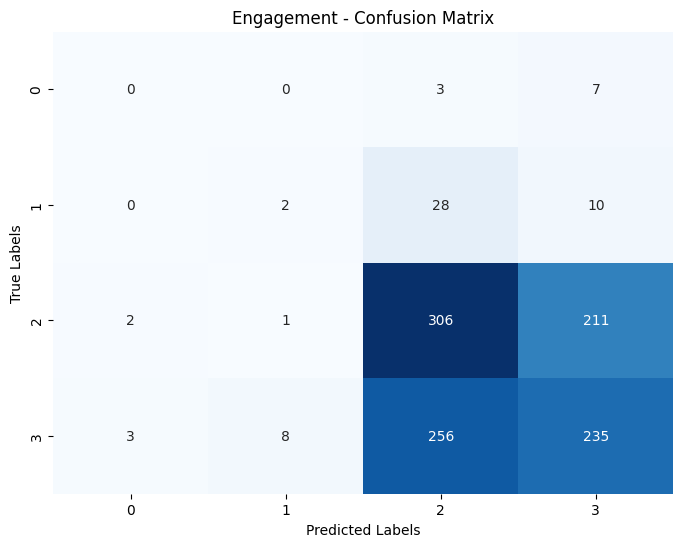

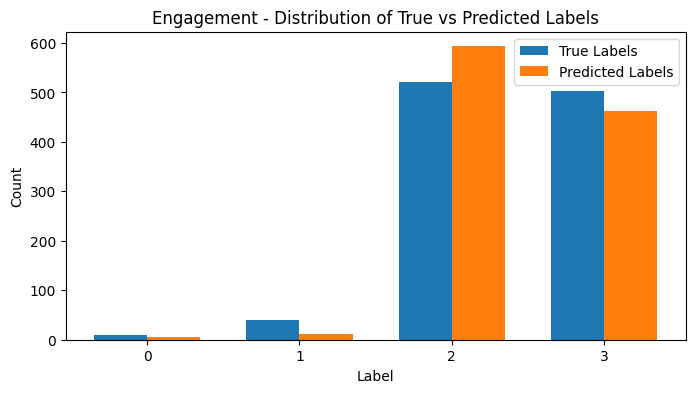


Evaluating model for Boredom...
Boredom validation accuracy: 0.4711

Classification Report:
              precision    recall  f1-score   support

           0     0.5595    0.6476    0.6004       508
           1     0.3878    0.3758    0.3817       322
           2     0.3250    0.2453    0.2796       212
           3     0.2500    0.1000    0.1429        30

    accuracy                         0.4711      1072
   macro avg     0.3806    0.3422    0.3511      1072
weighted avg     0.4529    0.4711    0.4584      1072

Confusion Matrix:
[[329 121  55   3]
 [150 121  47   4]
 [ 97  61  52   2]
 [ 12   9   6   3]]


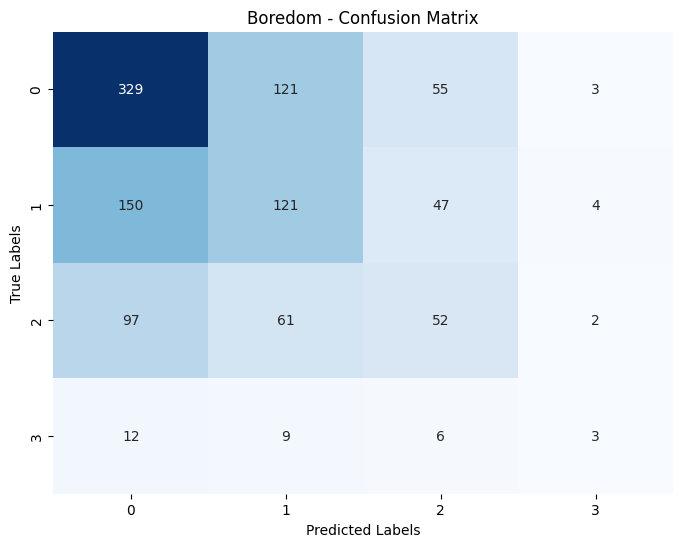

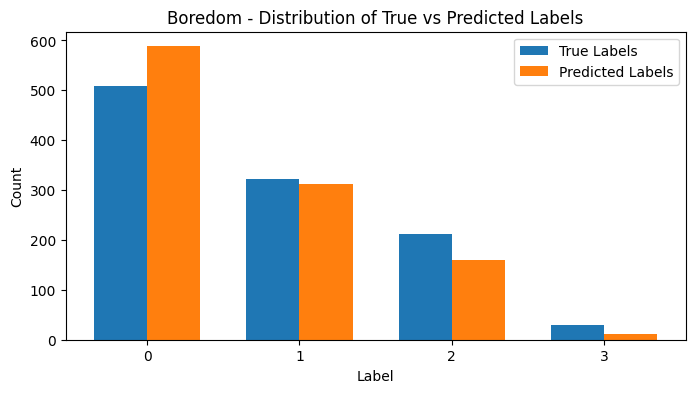


Evaluating model for Confusion...
Confusion validation accuracy: 0.6362

Classification Report:
              precision    recall  f1-score   support

           0     0.7019    0.8703    0.7771       725
           1     0.3529    0.1943    0.2507       247
           2     0.0938    0.0333    0.0492        90
           3     0.0000    0.0000    0.0000        10

    accuracy                         0.6362      1072
   macro avg     0.2871    0.2745    0.2692      1072
weighted avg     0.5639    0.6362    0.5874      1072

Confusion Matrix:
[[631  68  22   4]
 [194  48   5   0]
 [ 68  18   3   1]
 [  6   2   2   0]]


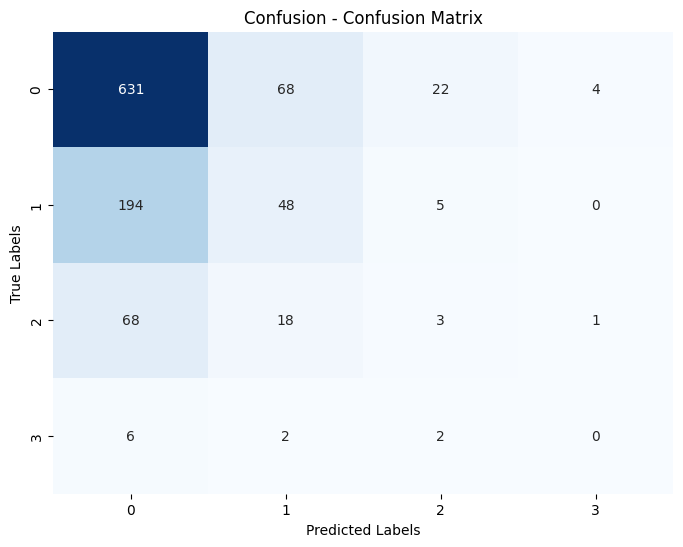

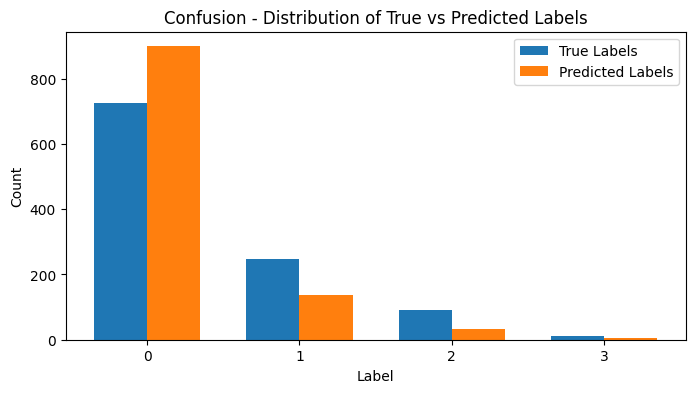


Evaluating model for Frustration...
Frustration validation accuracy: 0.7444

Classification Report:
              precision    recall  f1-score   support

           0     0.7822    0.9445    0.8557       829
           1     0.2542    0.0773    0.1186       194
           2     0.0000    0.0000    0.0000        35
           3     0.0000    0.0000    0.0000        14

    accuracy                         0.7444      1072
   macro avg     0.2591    0.2555    0.2436      1072
weighted avg     0.6509    0.7444    0.6832      1072

Confusion Matrix:
[[783  39   4   3]
 [175  15   4   0]
 [ 32   3   0   0]
 [ 11   2   1   0]]


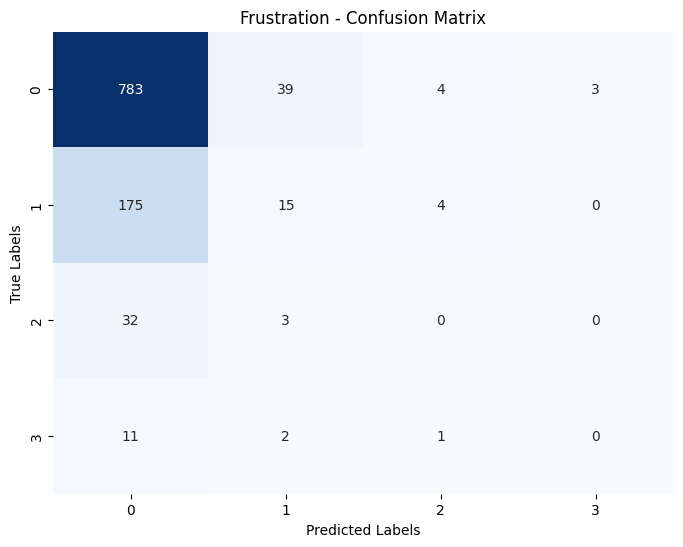

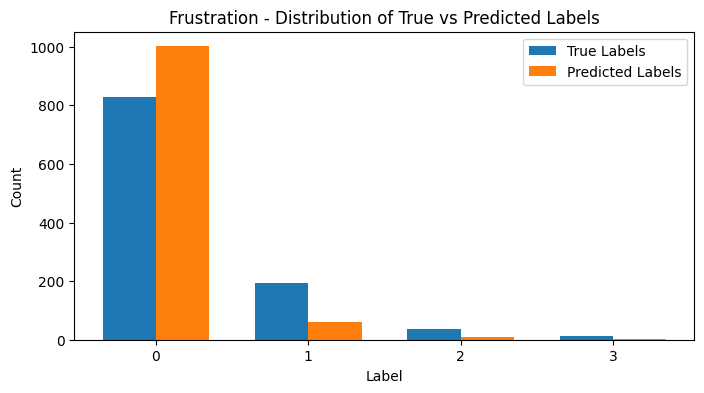


XGBoost HOG model training, evaluation, and visualizations complete for all metrics!


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np

# Define the list of metrics (ensure these match the cleaned column names in df_train)
metrics = ["Engagement", "Boredom", "Confusion", "Frustration"]

for metric in metrics:
    print(f"\nEvaluating model for {metric}...")
    
    # Load the saved model for the current metric
    model_path = MODEL_DIR / f"final_model_{metric}.model"
    booster = xgb.Booster()
    booster.load_model(str(model_path))
    
    # Extract labels for the current metric from df_train
    # (Ensure the column name is correct; for example, if the CSV had extra spaces, they should be stripped)
    y_metric = df_train[metric].astype(int).values
    
    # Split the data into training and validation sets (we only need the validation part here)
    # Using the same random_state to ensure consistency with training splits
    _, X_val_metric, _, y_val_metric = train_test_split(X, y_metric, test_size=0.2, random_state=42)
    
    # Create a DMatrix for the validation set and predict
    dX_val_metric = xgb.DMatrix(X_val_metric)
    preds = booster.predict(dX_val_metric)
    
    # Evaluate predictions
    acc = accuracy_score(y_val_metric, preds)
    print(f"{metric} validation accuracy: {acc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_val_metric, preds, digits=4))
    
    cm = confusion_matrix(y_val_metric, preds)
    print("Confusion Matrix:")
    print(cm)
    
    # --- Visualizations ---
    
    # 1. Confusion Matrix Heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"{metric} - Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()
    
    # 2. Bar Chart for Label Distribution
    true_counts = Counter(y_val_metric)
    pred_counts = Counter(preds)
    
    labels = sorted(set(y_val_metric))
    true_vals = [true_counts.get(label, 0) for label in labels]
    pred_vals = [pred_counts.get(label, 0) for label in labels]
    
    plt.figure(figsize=(8, 4))
    width = 0.35
    x = np.arange(len(labels))
    plt.bar(x - width/2, true_vals, width, label="True Labels")
    plt.bar(x + width/2, pred_vals, width, label="Predicted Labels")
    plt.xlabel("Label")
    plt.ylabel("Count")
    plt.title(f"{metric} - Distribution of True vs Predicted Labels")
    plt.xticks(x, labels)
    plt.legend()
    plt.show()
 
print("\nXGBoost HOG model training, evaluation, and visualizations complete for all metrics!")